# Loading and working with processed fetal Visium data - post cell2location deconvolution

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100
import openpyxl
from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
# %load_ext autoreload
# %autoreload 2

Running Scanpy 1.9.1, on 2024-09-20 11:21.


In [2]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("")
# print(font_manager.findfont("Arial"))
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [3]:
# output folder 
import os
os.chdir('')
# os.getcwd()

In [4]:
source_folder = ''

# Explore gene expression and cytokine profiles  

In [5]:
adata_fet_cma = sc.read_h5ad('')
adata_fet_cma

AnnData object with n_obs × n_vars = 10090 × 26745
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequen

In [6]:
adata_fet_cma.obs['annotations_level_1'].value_counts()

unassigned    9978
PVS            109
HC               3
Name: annotations_level_1, dtype: int64

# correlations with axis 

Capsular = (-0.75 > cma_v2)
Sub-Capsular = (-0.75 <= cma_v2) & (-0.62 > cma_v2)
Cortical level 1 = (-0.62 <= cma_v2) & (-0.55 > cma_v2)
Cortical level 2 = (-0.55 <= cma_v2) & (-0.45 > cma_v2)
Cortical level 3 = (-0.45 <= cma_v2) & (-0.3 > cma_v2)
Cortical CMJ = (-0.3 <= cma_v2) & (0.1 > cma_v2)
Medullar CMJ = (0.1 <= cma_v2) & (0.55 > cma_v2)
Medullar level 1 = (0.55 <= cma_v2) & (0.65 > cma_v2)
Medullar level 2 = (0.65 <= cma_v2) & (0.7 > cma_v2)
Medullar level 3 = (0.7 <= cma_v2)


Cortical level 2    1621
Capsular            1519
Cortical level 1    1347
Medullar CMJ        1145
Cortical level 3    1141
Medullar level 1     948
Cortical CMJ         912
Medullar level 2     615
Sub-Capsular         506
Medullar level 3     336
Name: manual_bin_cma_v2, dtype: int64

<AxesSubplot:>

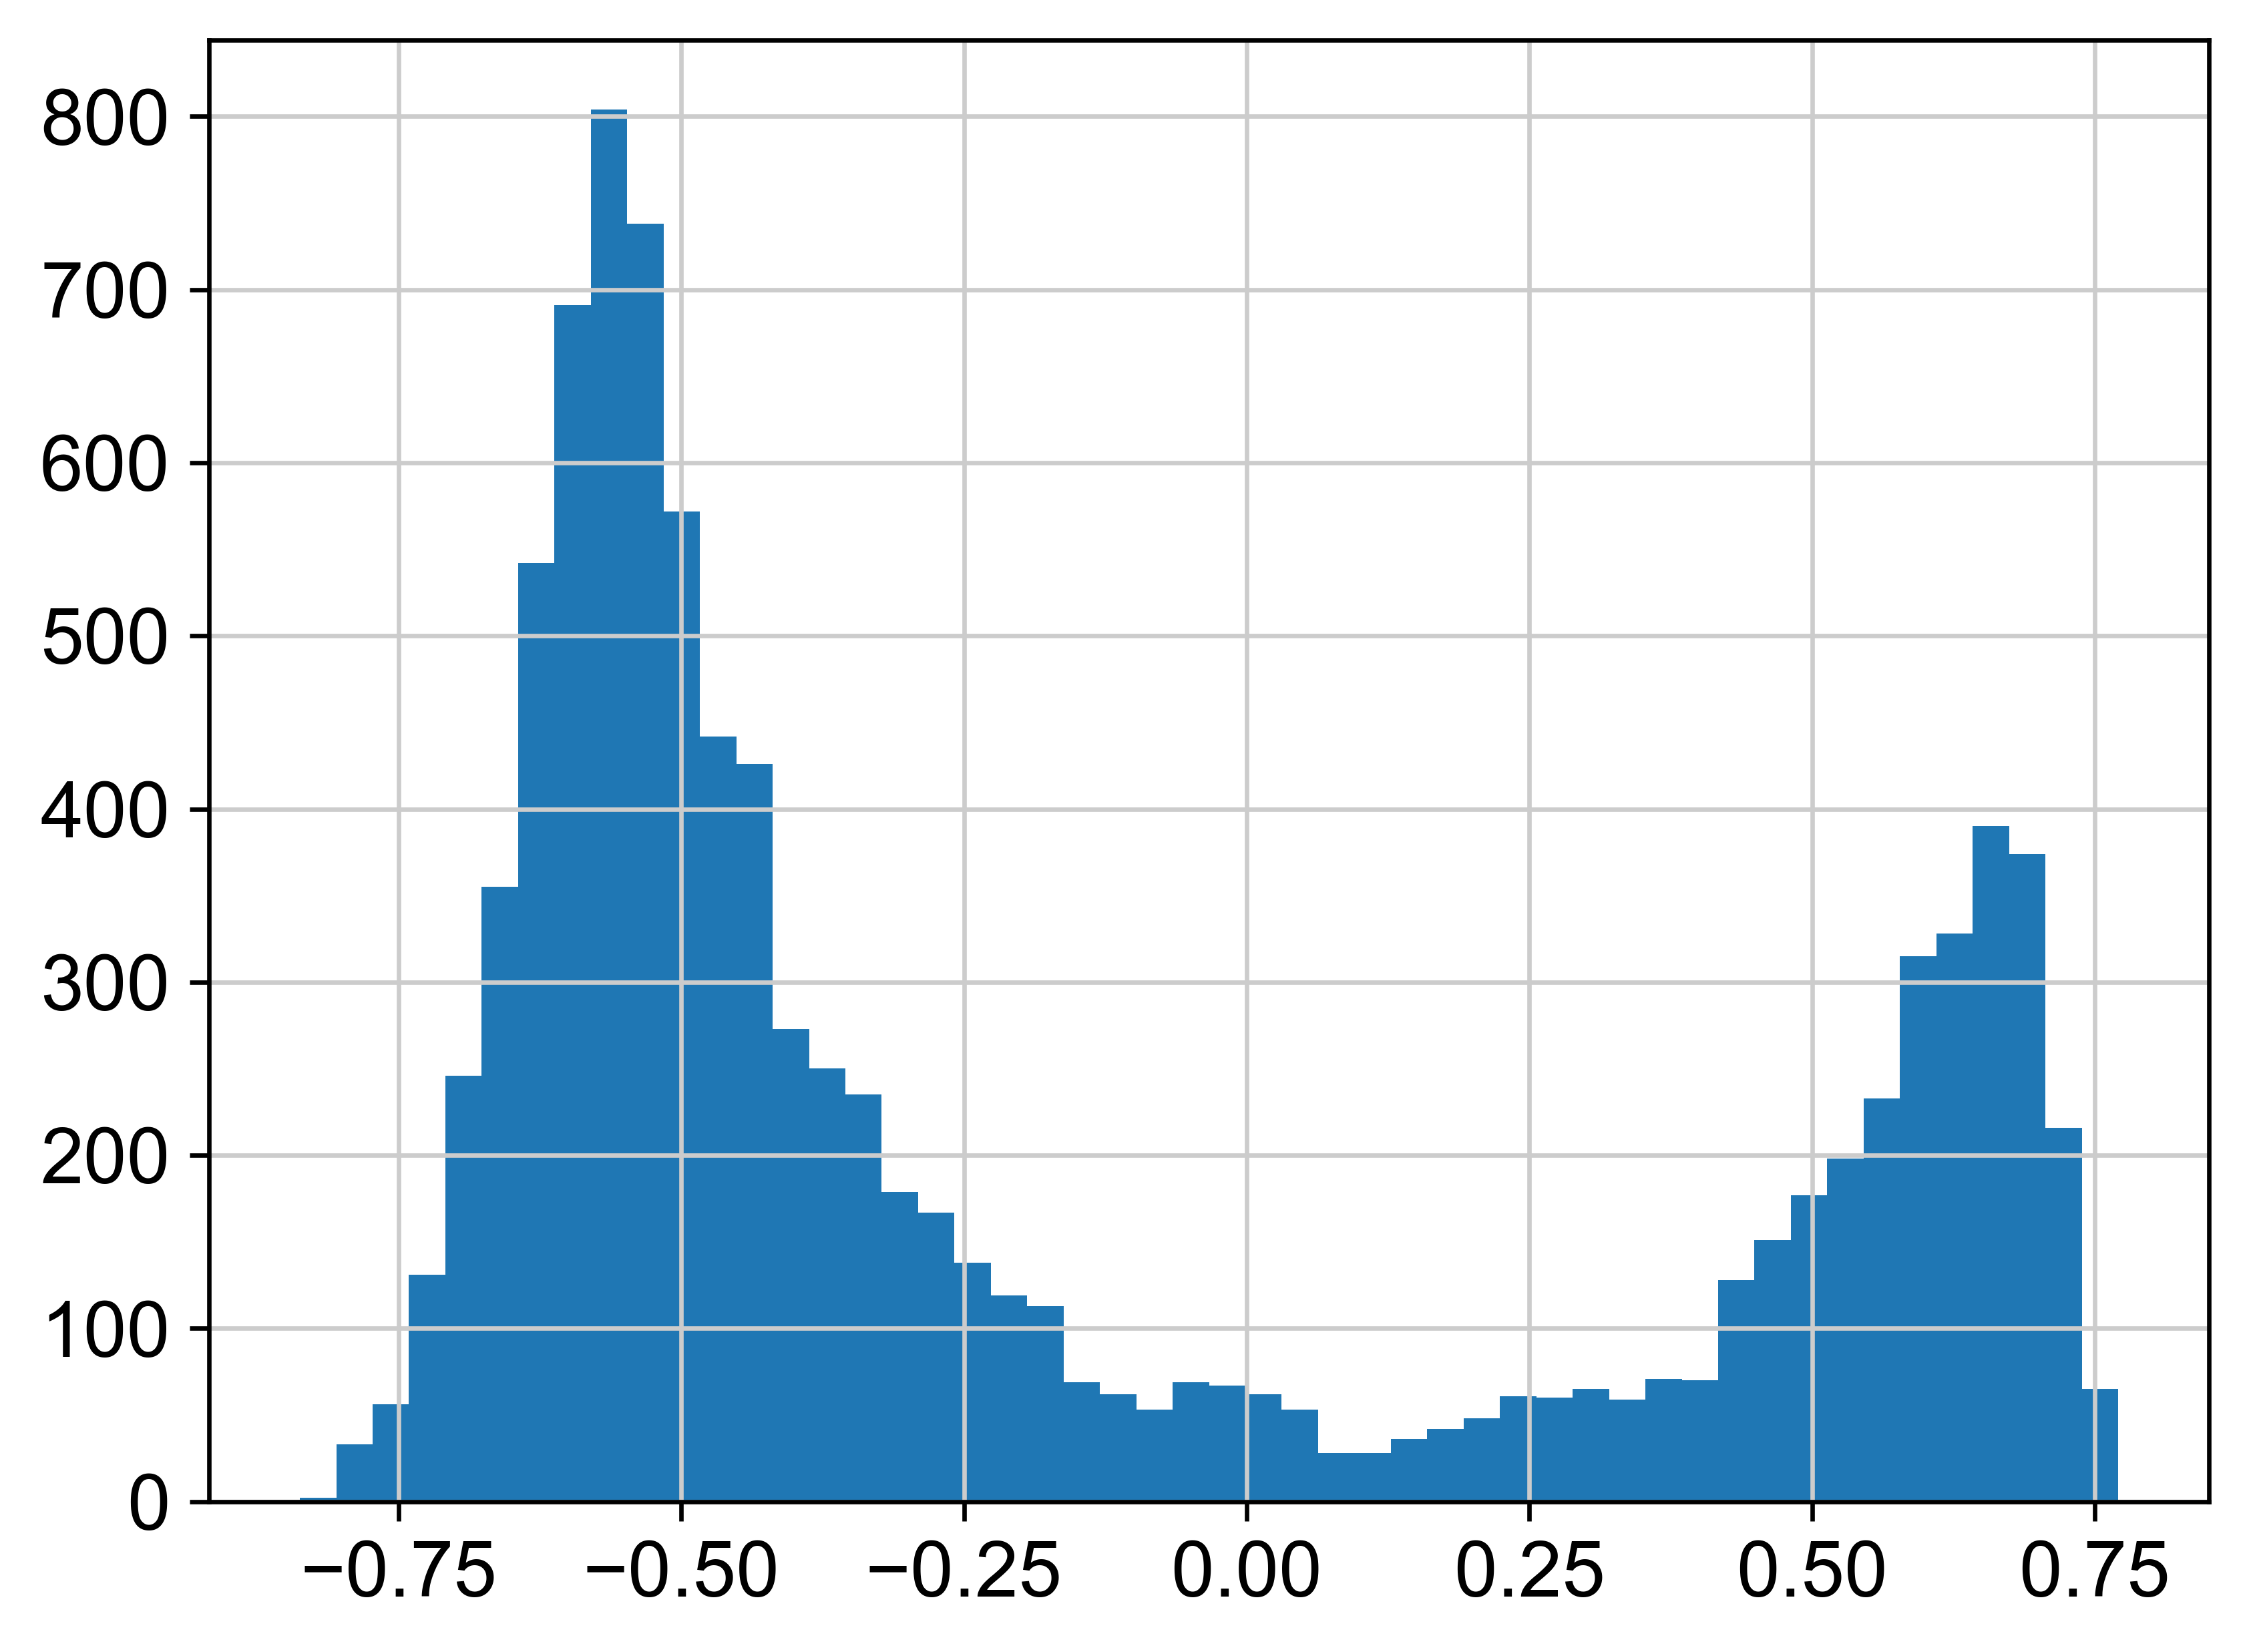

In [7]:
import imagespot_rev_v1 as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_fet_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_fet_cma.obs,'cma_v2')   
adata_fet_cma.obs.loc[adata_fet_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_fet_cma.obs['manual_bin_cma_v2'] = adata_fet_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_fet_cma.obs['manual_bin_cma_v2'].value_counts()
adata_fet_cma.obs['cma_v2'].hist(bins=50)
plt.show()

In [8]:
cytokines = pd.read_csv('',header=None)

['CXCL1', 'IL1RAP', 'CXCL6', 'IL1B', 'TNFSF12', 'IL1RN', 'TNFSF9', 'TNFSF11', 'CXCL10', 'IL7R', 'CD70', 'FLT3LG', 'IL23A', 'CCL20', 'CCL1', 'IL6ST', 'EBI3', 'CXCL11', 'CCL21', 'IL15', 'TNF', 'CXCL16', 'LTA', 'TNFSF13B', 'CCL19', 'IL4R', 'CD40LG', 'CXCL9', 'CCL22', 'CCL13', 'CCL3', 'CCL28', 'CX3CL1', 'CSF1', 'CCL4', 'CXCL13', 'IL12B', 'CXCL14', 'TNFSF13', 'IL6R', 'XCL1', 'IL18', 'XCL2', 'TNFSF14', 'CCL17', 'CCL5', 'CCL18', 'TNFSF10', 'IL15RA', 'IL17RE', 'CXCL8', 'CXCL3', 'BMP8A', 'CXCL12', 'CCL25', 'IL34', 'IL33', 'CCL2', 'IL1R1', 'BMP7', 'SPP1', 'CCL14', 'GDF11', 'IL1R2', 'TGFB3']


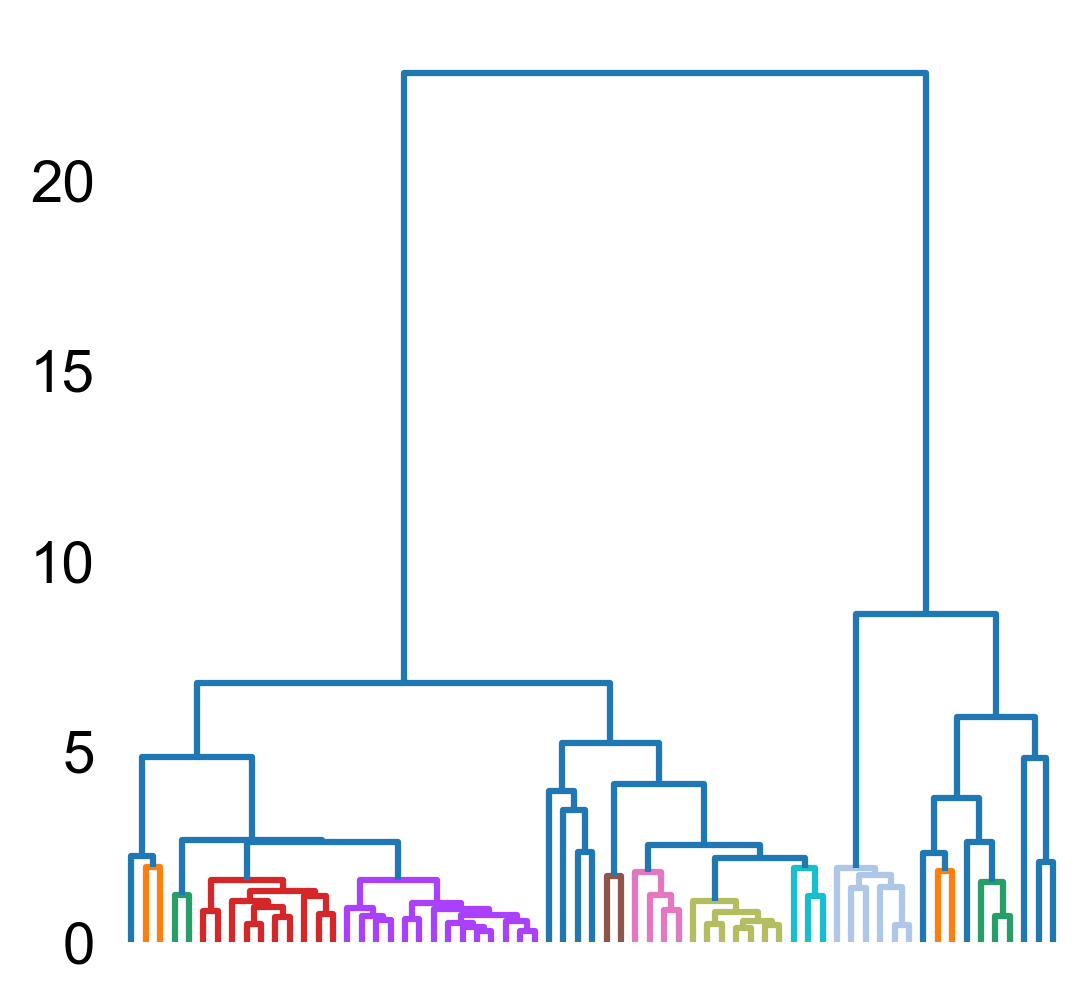

In [9]:
# cluster cytokies by expression profiles across bins
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, dendrogram

## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')
os.chdir('')


# Subset dataframe, calculate mean expression and standardize
adata_selected = adata_fet_cma[:, adata_fet_cma.var_names.isin(cytokines[0])]
mean_expression_df = pd.DataFrame(adata_selected.X.toarray(), 
                                  columns=adata_selected.var_names, 
                                  index=adata_selected.obs_names).groupby(adata_fet_cma.obs['manual_bin_cma_v2']).mean()
mean_expression_std = pd.DataFrame(scale(mean_expression_df, axis=0),
                                   index=mean_expression_df.index,
                                   columns=mean_expression_df.columns)

# Create dendrogram
transposed_df = mean_expression_std.transpose()
Z = linkage(transposed_df, method='ward')
dn = dendrogram(Z, orientation='top', labels=transposed_df.index, leaf_font_size=5,p=10,color_threshold=2)

# Set plotting preferences
plt.grid(False)
plt.rcParams['figure.facecolor'] = 'white'
for spine in plt.gca().spines.values(): spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)

# Get and print gene order
gene_order = [transposed_df.index[i] for i in dn['leaves']]
print(gene_order)

# Save the dendrogram figure as a PDF
plt.savefig('')

plt.show()

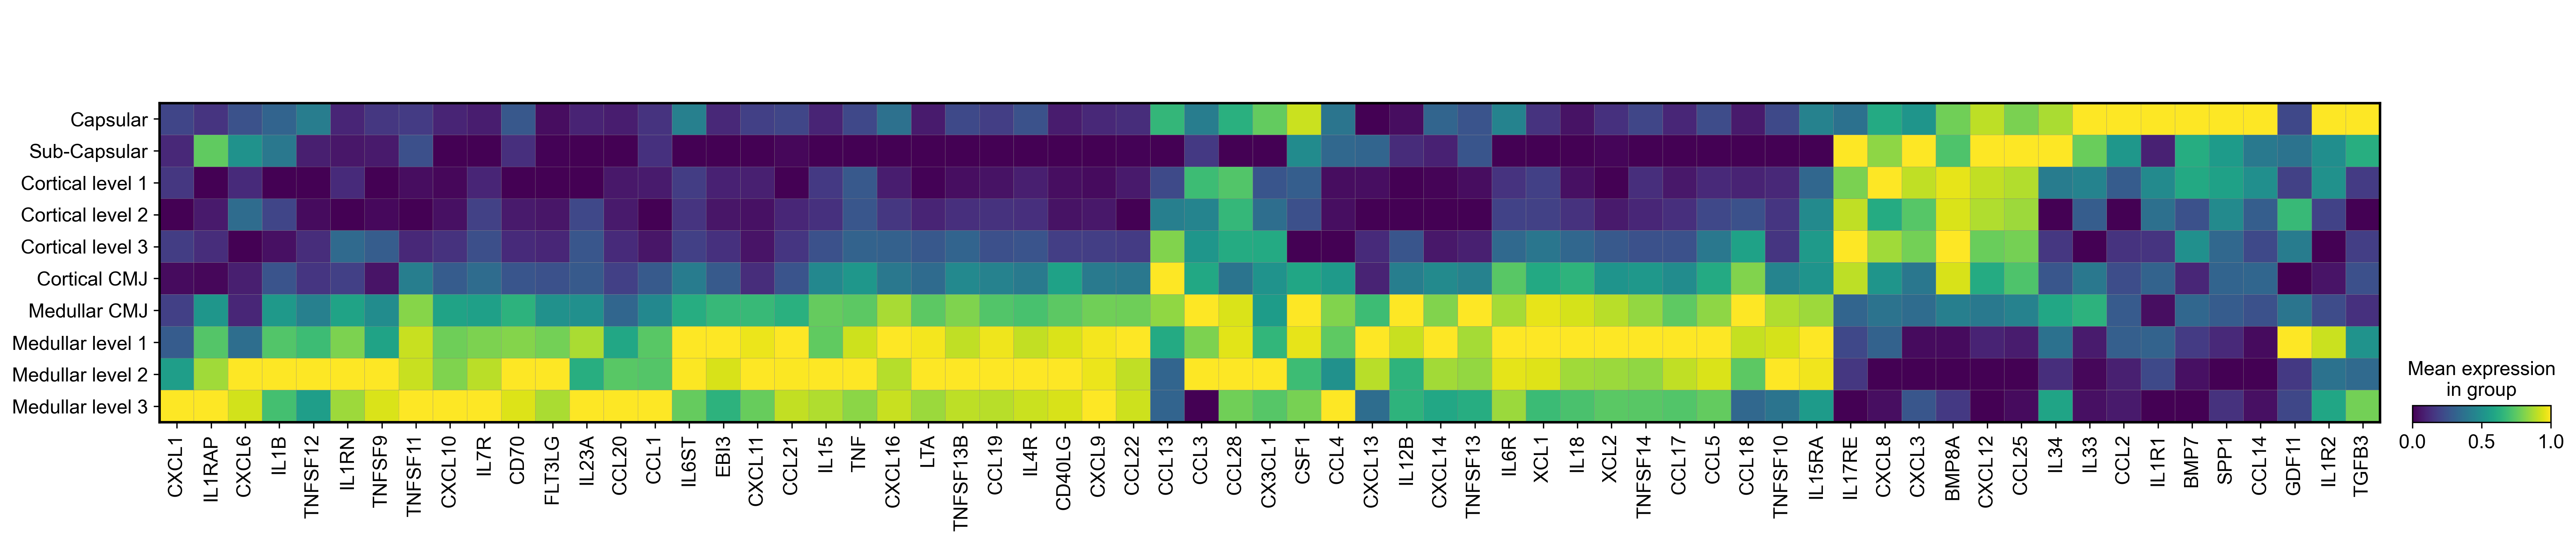

In [10]:
# Create matrix plot using scanpy and return the figure object
cyt_mtx_plot = sc.pl.matrixplot(
    adata_fet_cma,
    var_names=gene_order,
    groupby='manual_bin_cma_v2',
    cmap='viridis',
    standard_scale='var',
    dendrogram=False,
    return_fig=True
)

# Save the plot manually using savefig
cyt_mtx_plot.savefig('')

# Optionally, show the plot
# cyt_mtx_plot.show()


In [11]:
np.save('', gene_order)

In [12]:
with pd.ExcelWriter(f'{source_folder}/Fetal_cytokine_mtx_.xlsx', engine='openpyxl') as writer:
        # Write the first title
        cyt_mtx_plot.values_df.to_excel(writer, index=True, header=True, startrow=0, sheet_name='Sheet1')
#         print (f'{source_folder}/Fetal_cytokine_mtx_.xlsx has been written')

# Analyse cell level

In [13]:
celltypes = adata_fet_cma.uns['mod']['factor_names']
cellab_fet = sc.AnnData(adata_fet_cma.obs[celltypes], 
                         obs = adata_fet_cma.obs.drop(celltypes, axis = 1),obsm = adata_fet_cma.obsm)
 
cellab_fet.var_names
sc.pp.normalize_total(cellab_fet,target_sum=100)
os.chdir('')


Index(['B-Prolif', 'B-memory', 'B-naive', 'DC1', 'DC1-Prolif', 'DC2',
       'DC2-Prolif', 'EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif',
       'EC-Lymphatic', 'EC-Ven', 'EC-Ven-ELN', 'GMP', 'InterloFb',
       'InterloFb-COL9A3', 'Macrophage-APOC2', 'Macrophage-LYVE1',
       'Macrophage-SPIC1', 'Mast', 'Mesothelium', 'Monocyte_IL1B', 'Pericyte',
       'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'PeriloFb-Prolif',
       'ProlifPericyte', 'Promonocyte', 'RBC', 'SMC', 'Schwann',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'TEC-tuft', 'T_CD4', 'T_CD8',
       'T_CD8-Prolif', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_CD8αα(entry)',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)',
       'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP', 'T_NK',
       'T_NK_fetal', 'T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2',
       'T_Treg_mature', 'T_Treg_recirc', 'T_cycling', 'T_innate_type_1',
       'T_innate_type_3', 'T_αβT(entry)', 'T_γδT', 'aDC1', 'aDC3', 

In [14]:
cells = {'CD8aa': [ 'T_CD8αα(entry)','T_CD8αα(I)', 'T_CD8αα(II)'],
         'DP':['T_DP(P)', 'T_DP(Q)','T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj'],
         'DP_other':['T_DP(Q)-CD99','T_DP(Q)-late_vdj'],
         'SP_other':['T_CD8-Prolif','T_cycling'],
         'Treg':['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2','T_Treg_mature', 'T_Treg_recirc',],
         'DN':['T_ETP', 'T_DN(early)', 'T_DN(P)', 'T_DN(Q)'],
         'innate':[ 'T_γδT','T_NK'], # rename nk_fetal to T_SP_fetal_ambigouous
         'B': ['small_pre_B','pro_B','late_pro_B','B-Prolif', 'B-memory', 'B-naive',],
         'DC': ['pDC', 'DC1-Prolif','DC1','aDC1', 'DC2-Prolif','DC2', 'aDC3'],
         'EC': ['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif', 'EC-Ven', 'EC-Ven-ELN','EC-Lymphatic',],
         'FB':['PeriloFb', 'PeriloFb-Prolif','InterloFb','InterloFb-COL9A3', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh'],
         'pericyte':['Pericyte','Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte','SMC'],
         'other':['GMP','Mast', 'Mesothelium', 'Monocyte_IL1B', 'Promonocyte', 'RBC', 'SMC', 'Schwann','nmSchwann',],
         'mono':[ 'Monocyte_IL1B', 'Promonocyte','Mast', 'RBC'],
         'MAC':['Macrophage-APOC2', 'Macrophage-LYVE1','Macrophage-SPIC1',],
         'Early':['T_ETP', 'T_DN(early)'],
         'TEC_fig4':['cTECII','cTECI','mcTEC-Prolif','mcTEC',  'mTECI', 'mTECII', 'mTECIII',],
         'TEC_special':['mTECI-trans','TEC-myo', 'TEC-neuro','TEC-cilliated', ],
         'T_traj':['T_DN(P)', 'T_DN(Q)','T_DP(P)','T_DP(Q)-early','T_DP(Q)','T_αβT(entry)', 'T_CD4', 'T_CD8']
        }


In [15]:
def export_Source_dotplot (Dotplot_obj, path, name):
    title1 = pd.DataFrame(['Cell type abundance'], columns=['Title'])
    df1 = Dotplot_obj.dot_color_df
    title2 = pd.DataFrame(['Cell type proportion'], columns=['Title'])
    df2 = Dotplot_obj.dot_size_df
    # Create an Excel writer object
    with pd.ExcelWriter(f'{path}/{name}.xlsx', engine='openpyxl') as writer:
        # Write the first title
        title1.to_excel(writer, index=False, header=False, startrow=0, sheet_name='Sheet1')
        # Write the first dataframe
        df1.to_excel(writer, startrow=1, sheet_name='Sheet1')
        # Calculate the row to start the second title
        startrow = len(df1) + 3  # Adding 4 rows for spacer and title
        # Write the second title
        title2.to_excel(writer, index=False, header=False, startrow=startrow, sheet_name='Sheet1')
        # Write the second dataframe
        df2.to_excel(writer, startrow=startrow+1, sheet_name='Sheet1')
        print (f'{path}/{name}.xlsx has been written')

Early
['T_ETP', 'T_DN(early)']


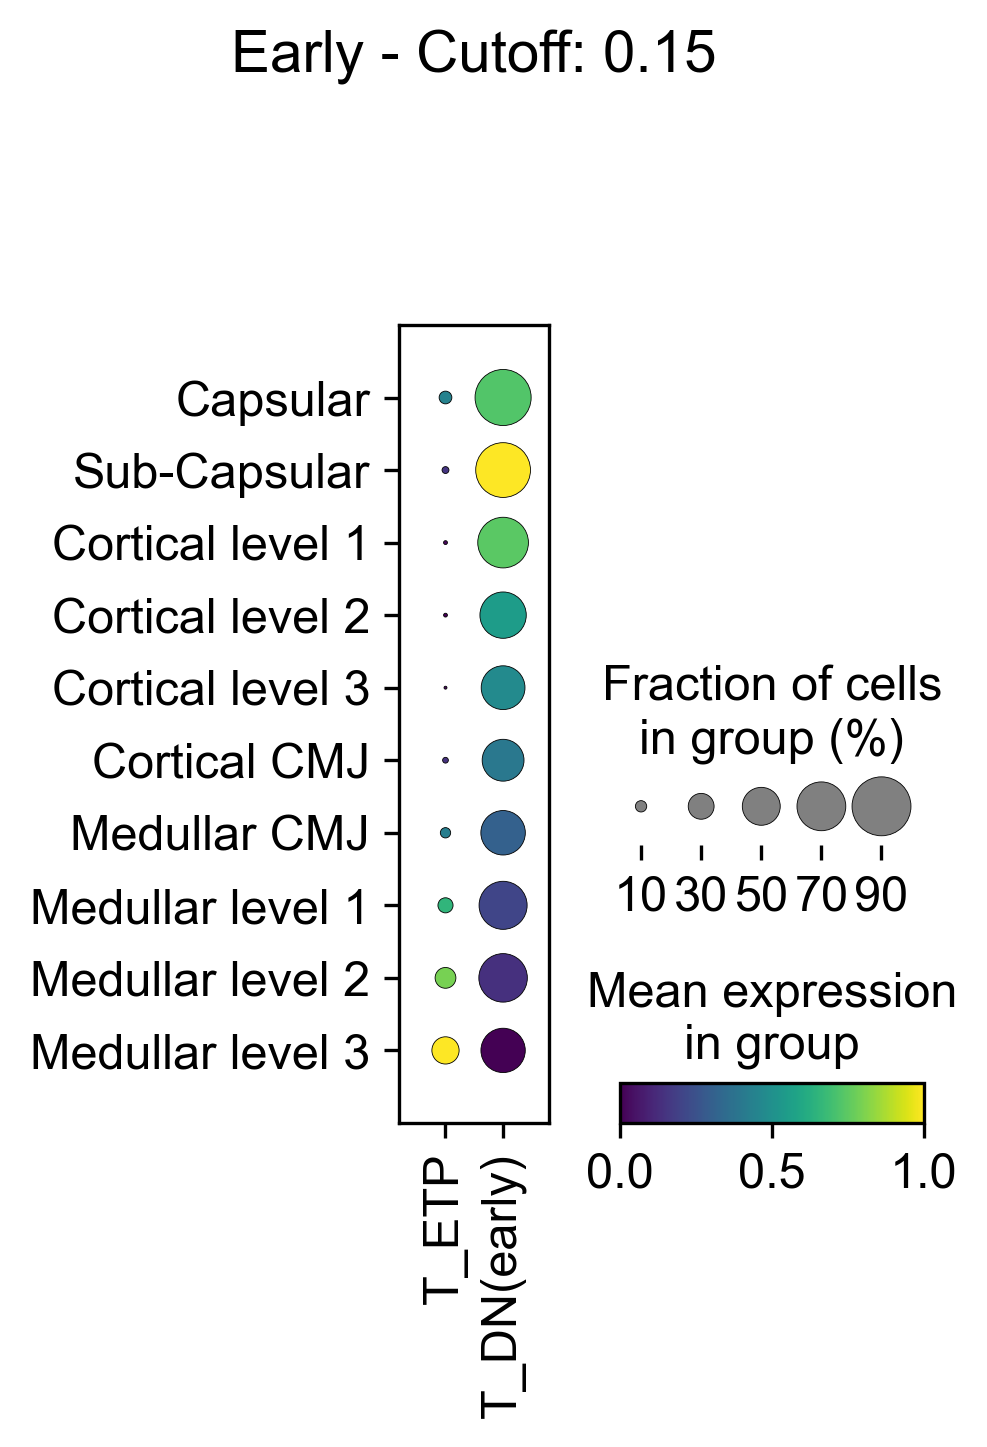

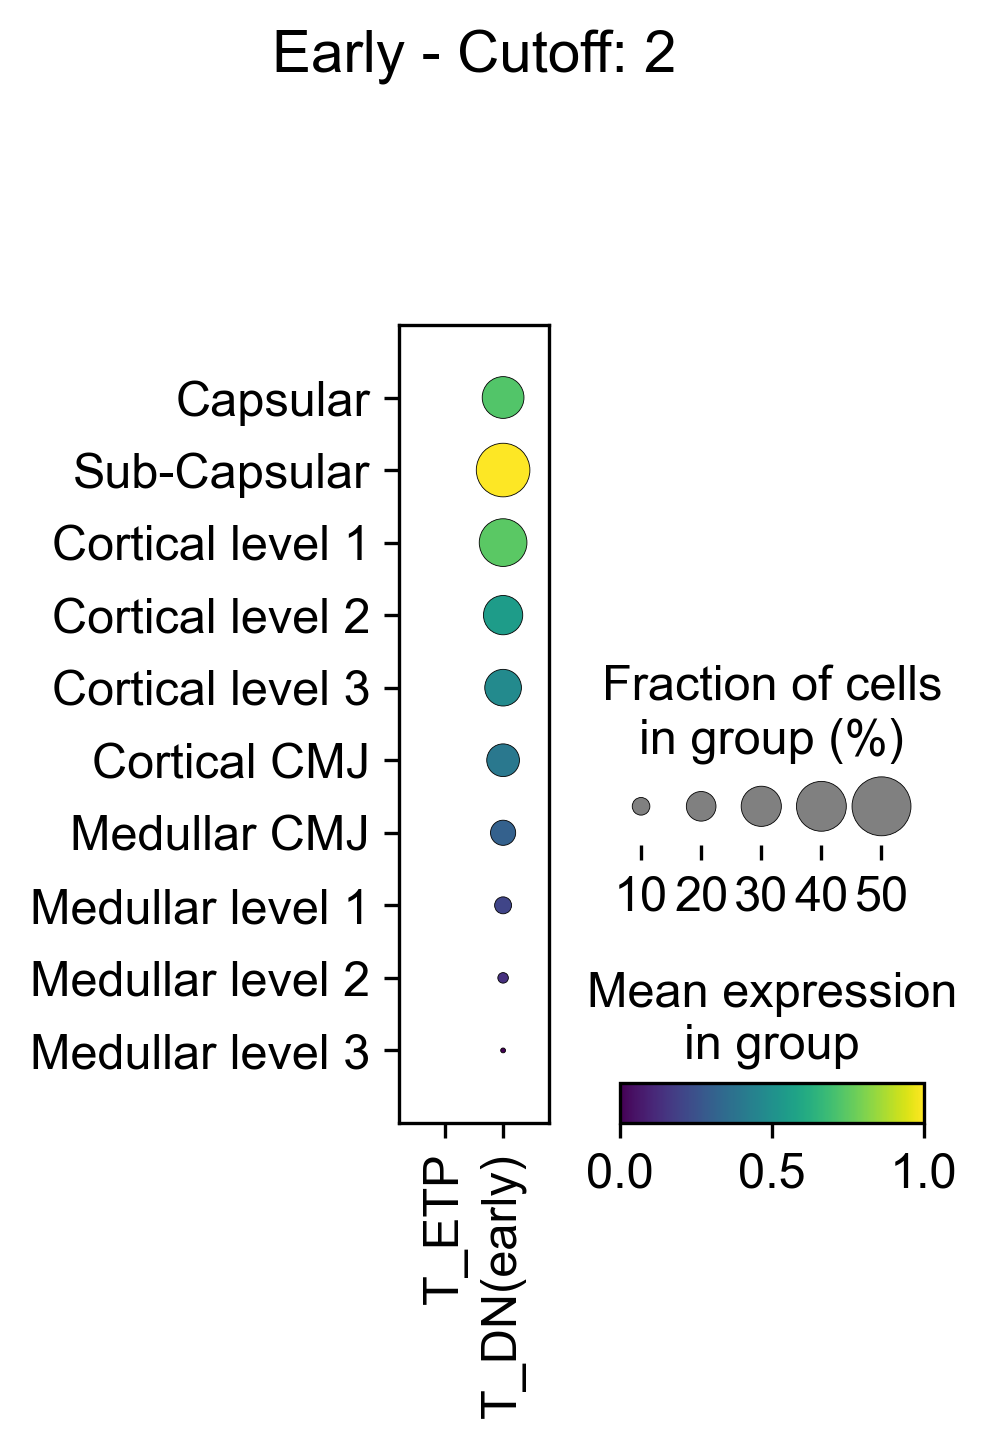

T_traj
['T_DN(P)', 'T_DN(Q)', 'T_DP(P)', 'T_DP(Q)-early', 'T_DP(Q)', 'T_αβT(entry)', 'T_CD4', 'T_CD8']


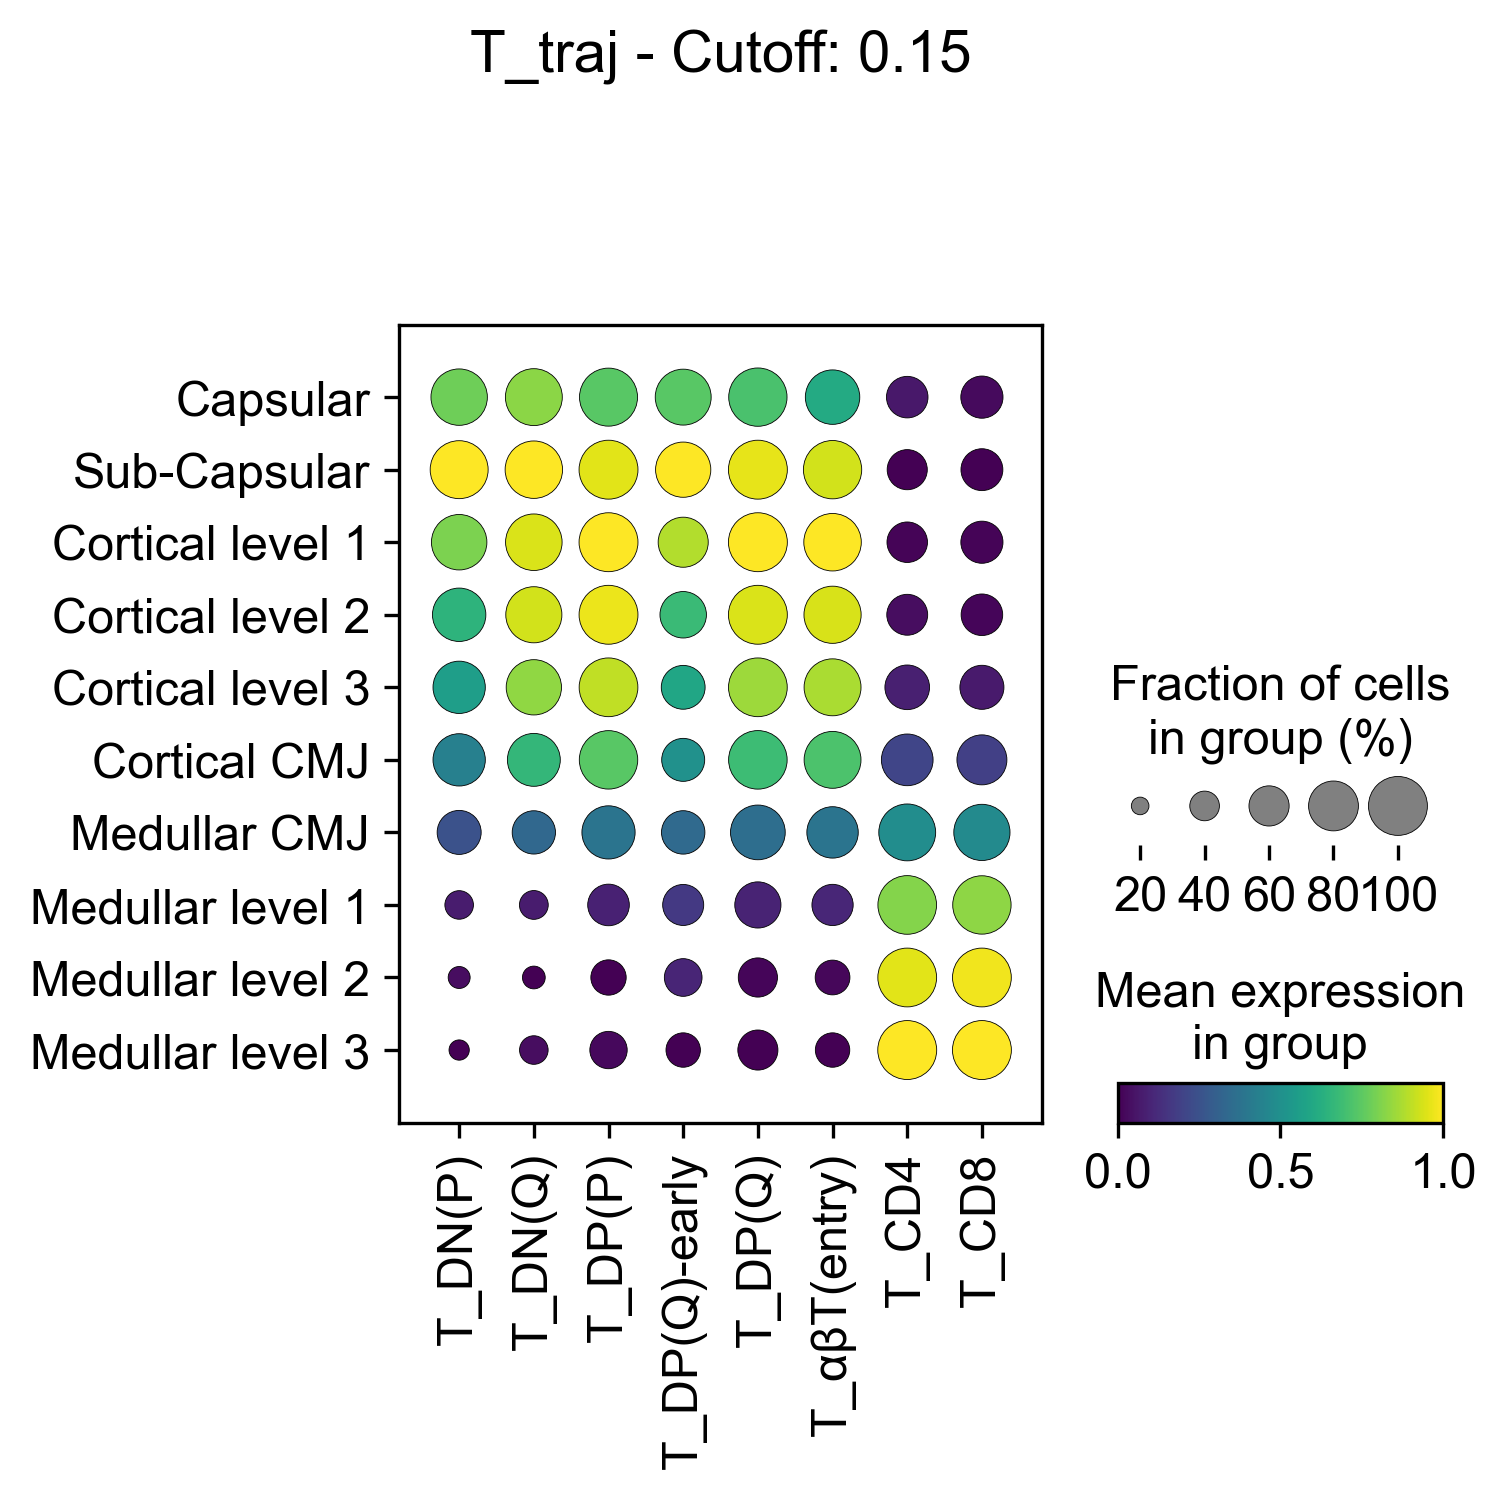

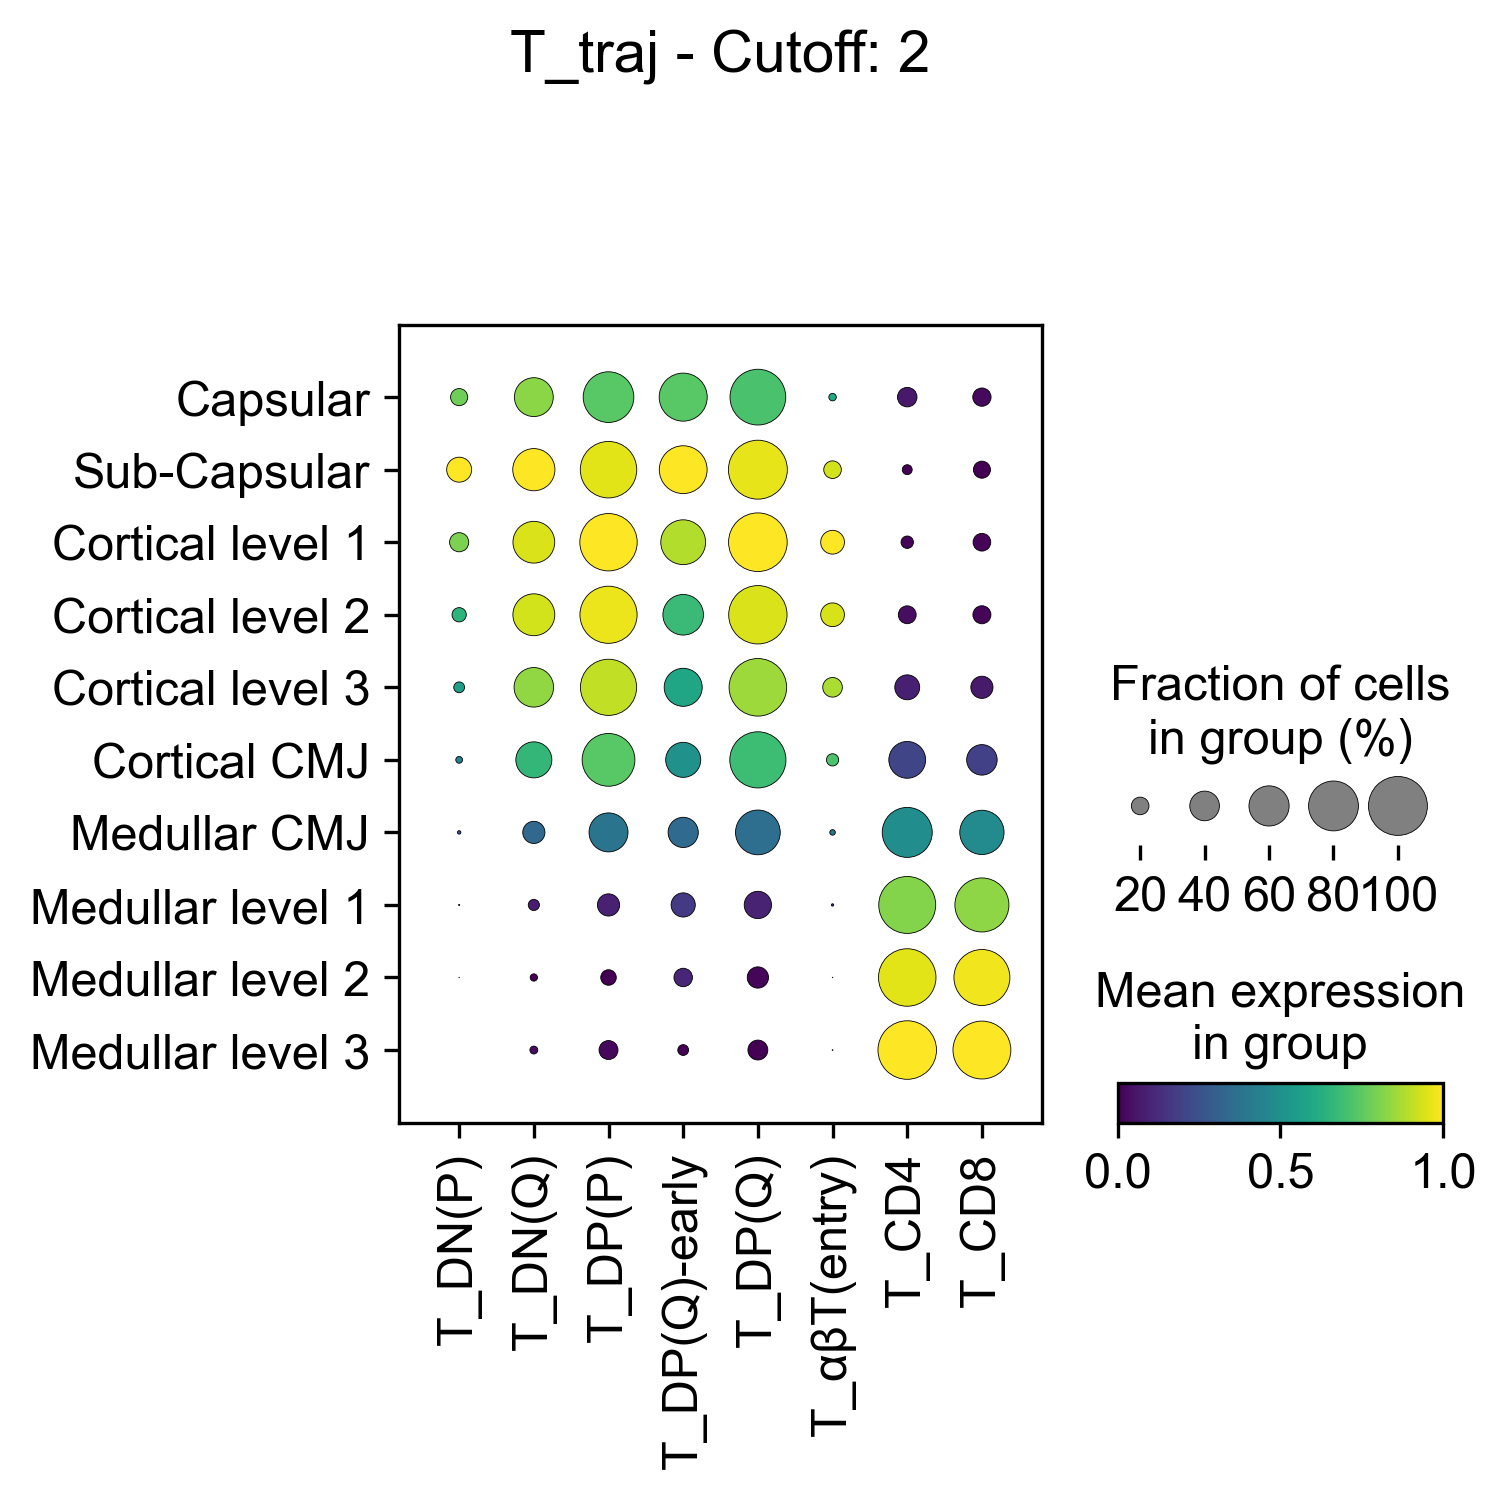

In [16]:
# subset cells
os.chdir('')

subset_keys = ['Early', 'T_traj']
cells_subset = {k: cells[k] for k in subset_keys}
 
# sc.set_figure_params(figsize=[7, 7], fontsize=12, dpi=200)

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    for cutoff in [0.15,2]:
        save_path = None
#         save_path = f'fetal_{cell}_cutoff_{cutoff}_F121.pdf'  # Construct the file name
#         dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
#                       groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff}',
#                       expression_cutoff=cutoff, standard_scale='var', return_fig = True, save=save_path)
#         export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff}_fetal_Visdotplot_source_data_F121")
#         dp.show()
#         dp.savefig(f'figures/{save_path}')
        
        sc.pl.dotplot(cellab_fet, var_names=cell_types,
                      groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff}',
                      expression_cutoff=cutoff, standard_scale='var', save=save_path)

# plot other T cells

SP_other
['T_CD8-Prolif', 'T_cycling']


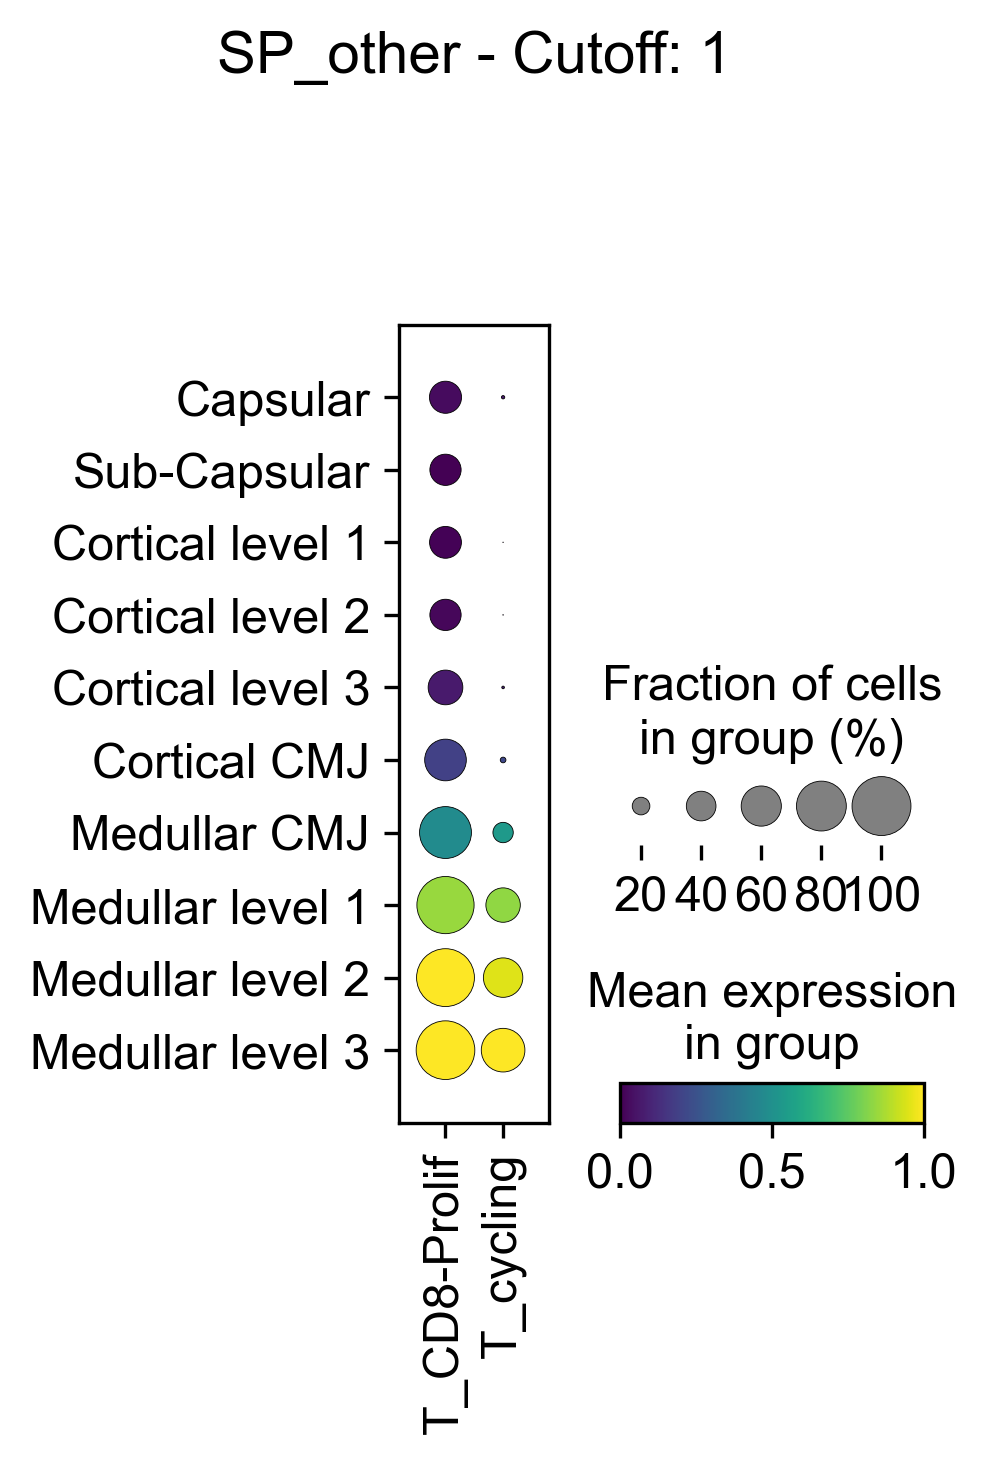

Treg
['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_mature', 'T_Treg_recirc']


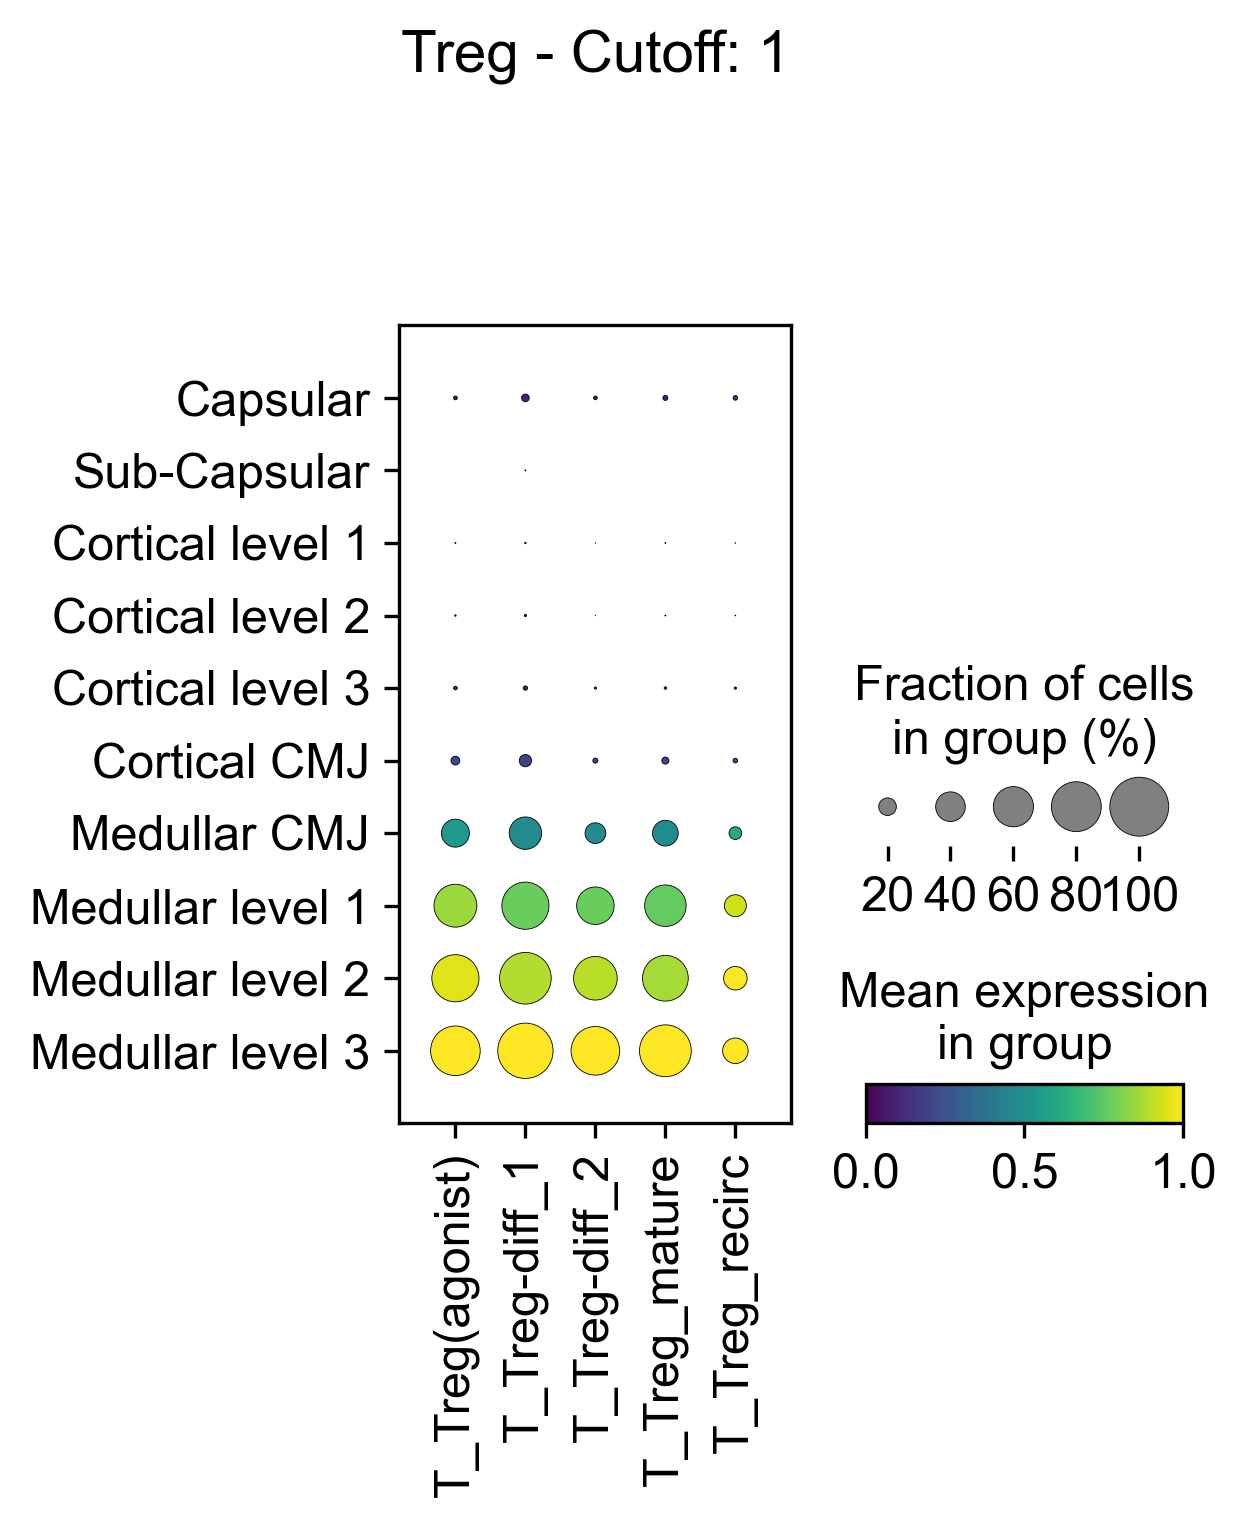

innate
['T_γδT', 'T_NK']


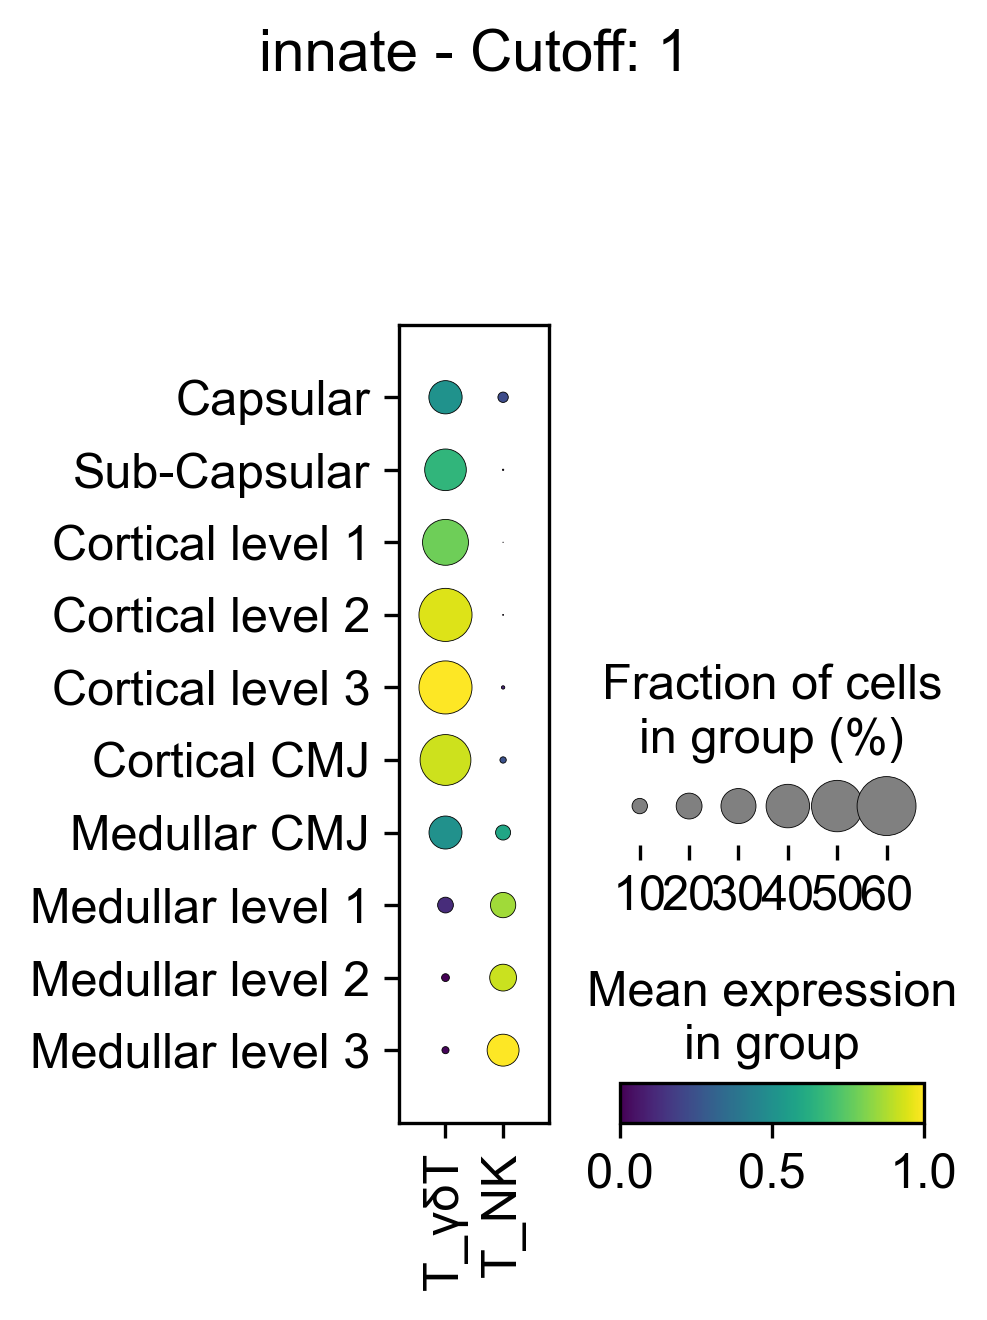

CD8aa
['T_CD8αα(entry)', 'T_CD8αα(I)', 'T_CD8αα(II)']


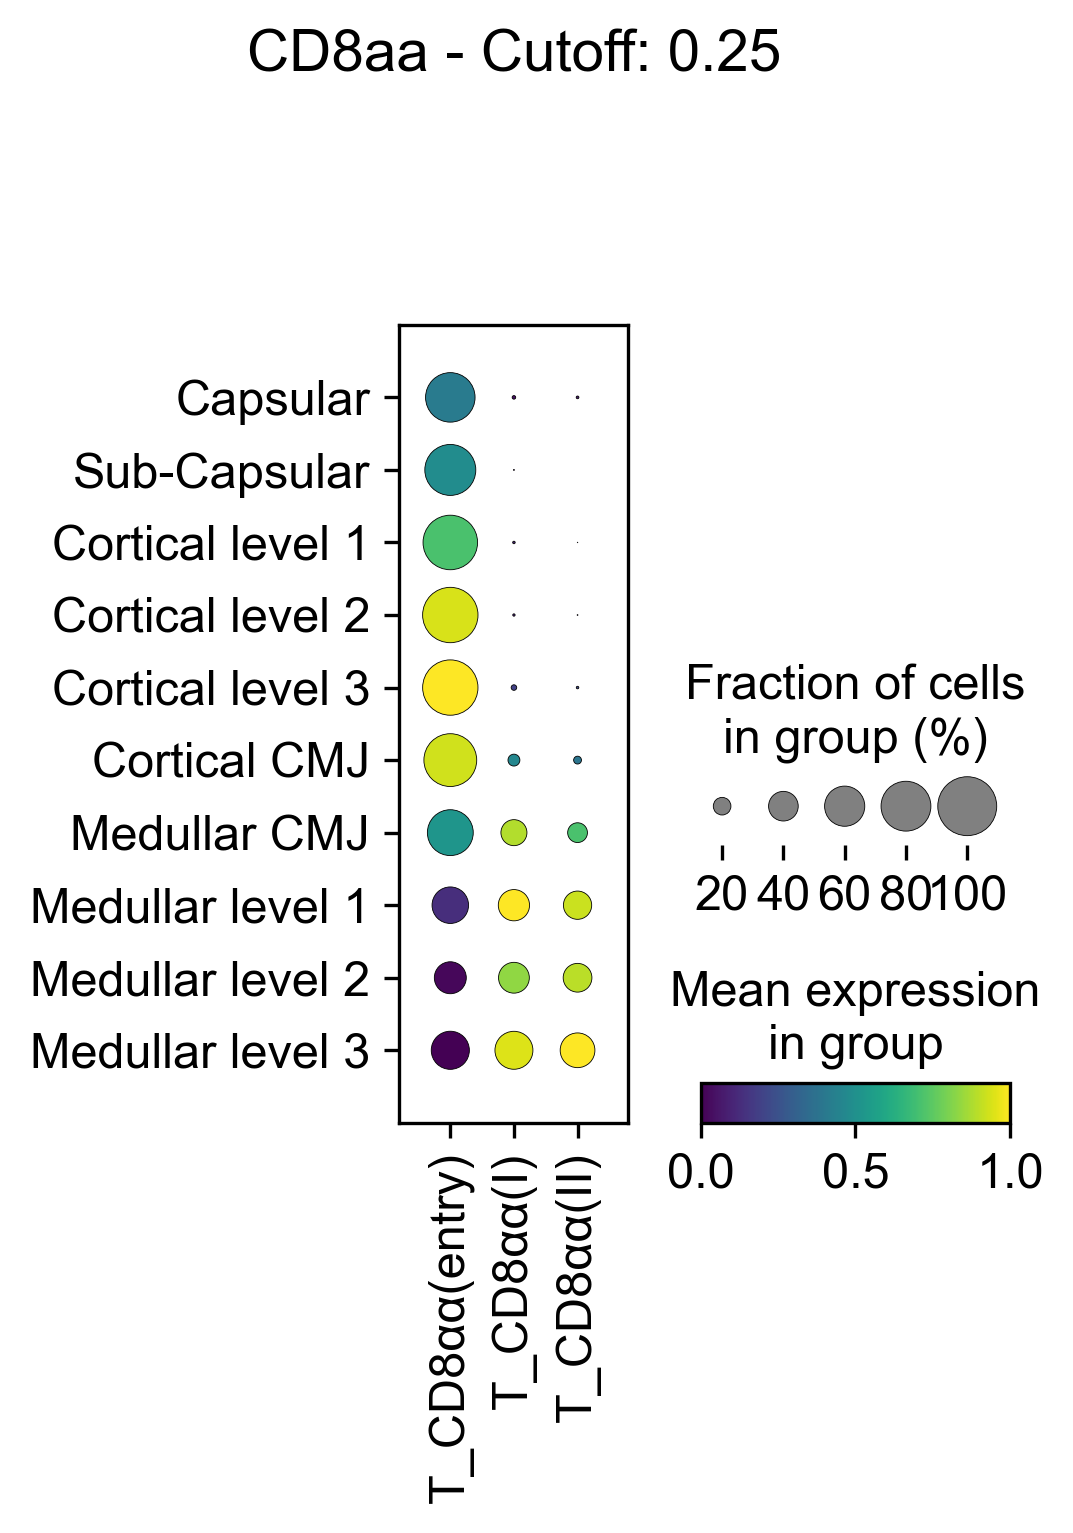

In [17]:
# subset cells
os.chdir('')

subset_keys = ['SP_other','Treg','innate','CD8aa']
cutoff = {'Treg':1,'SP_other':1,'innate':1,'CD8aa':0.25}
cells_subset = {k: cells[k] for k in subset_keys}
 
for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = None
#     save_path = f'fetal_{cell}_cutoff_{cutoff[cell]}_F121.pdf'  # Construct the file name
#     dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
#               groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
#                       expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True) # save=save_path
#     export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff[cell]}_fetal_Visdotplot_source_data_")
#     dp.show()
#     dp.savefig(f'figures/{save_path}')
    sc.pl.dotplot(cellab_fet, var_names=cell_types,
                      groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                      expression_cutoff=cutoff[cell], standard_scale='var', save=save_path)

B
['small_pre_B', 'pro_B', 'late_pro_B', 'B-Prolif', 'B-memory', 'B-naive']


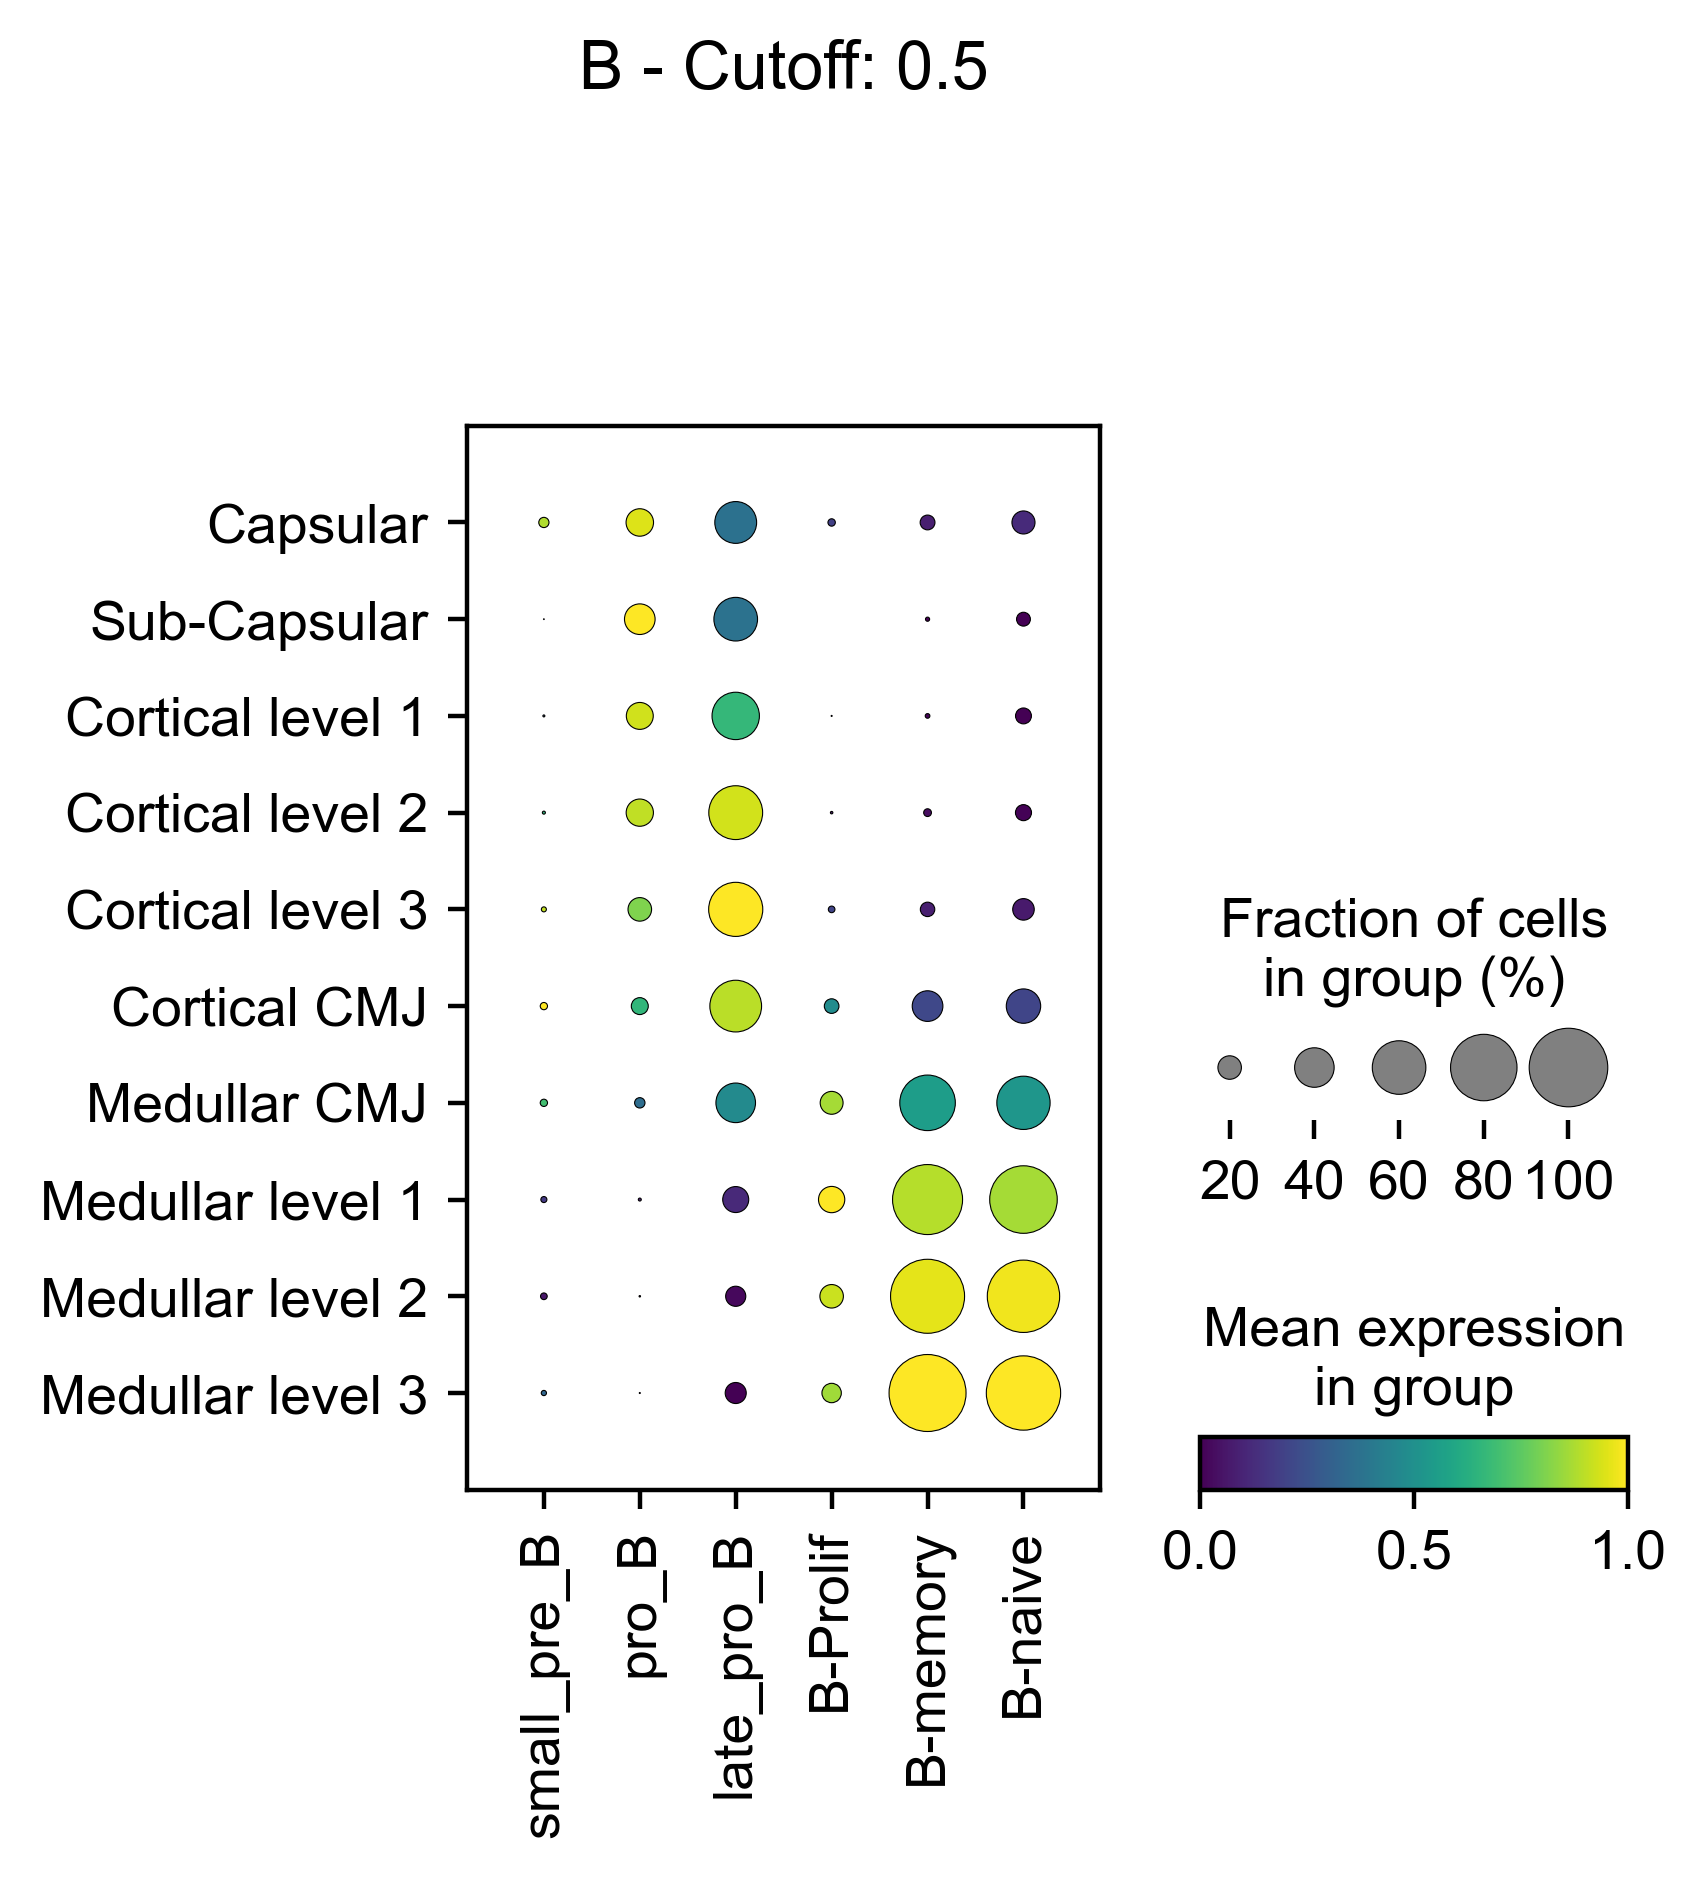

DC
['pDC', 'DC1-Prolif', 'DC1', 'aDC1', 'DC2-Prolif', 'DC2', 'aDC3']


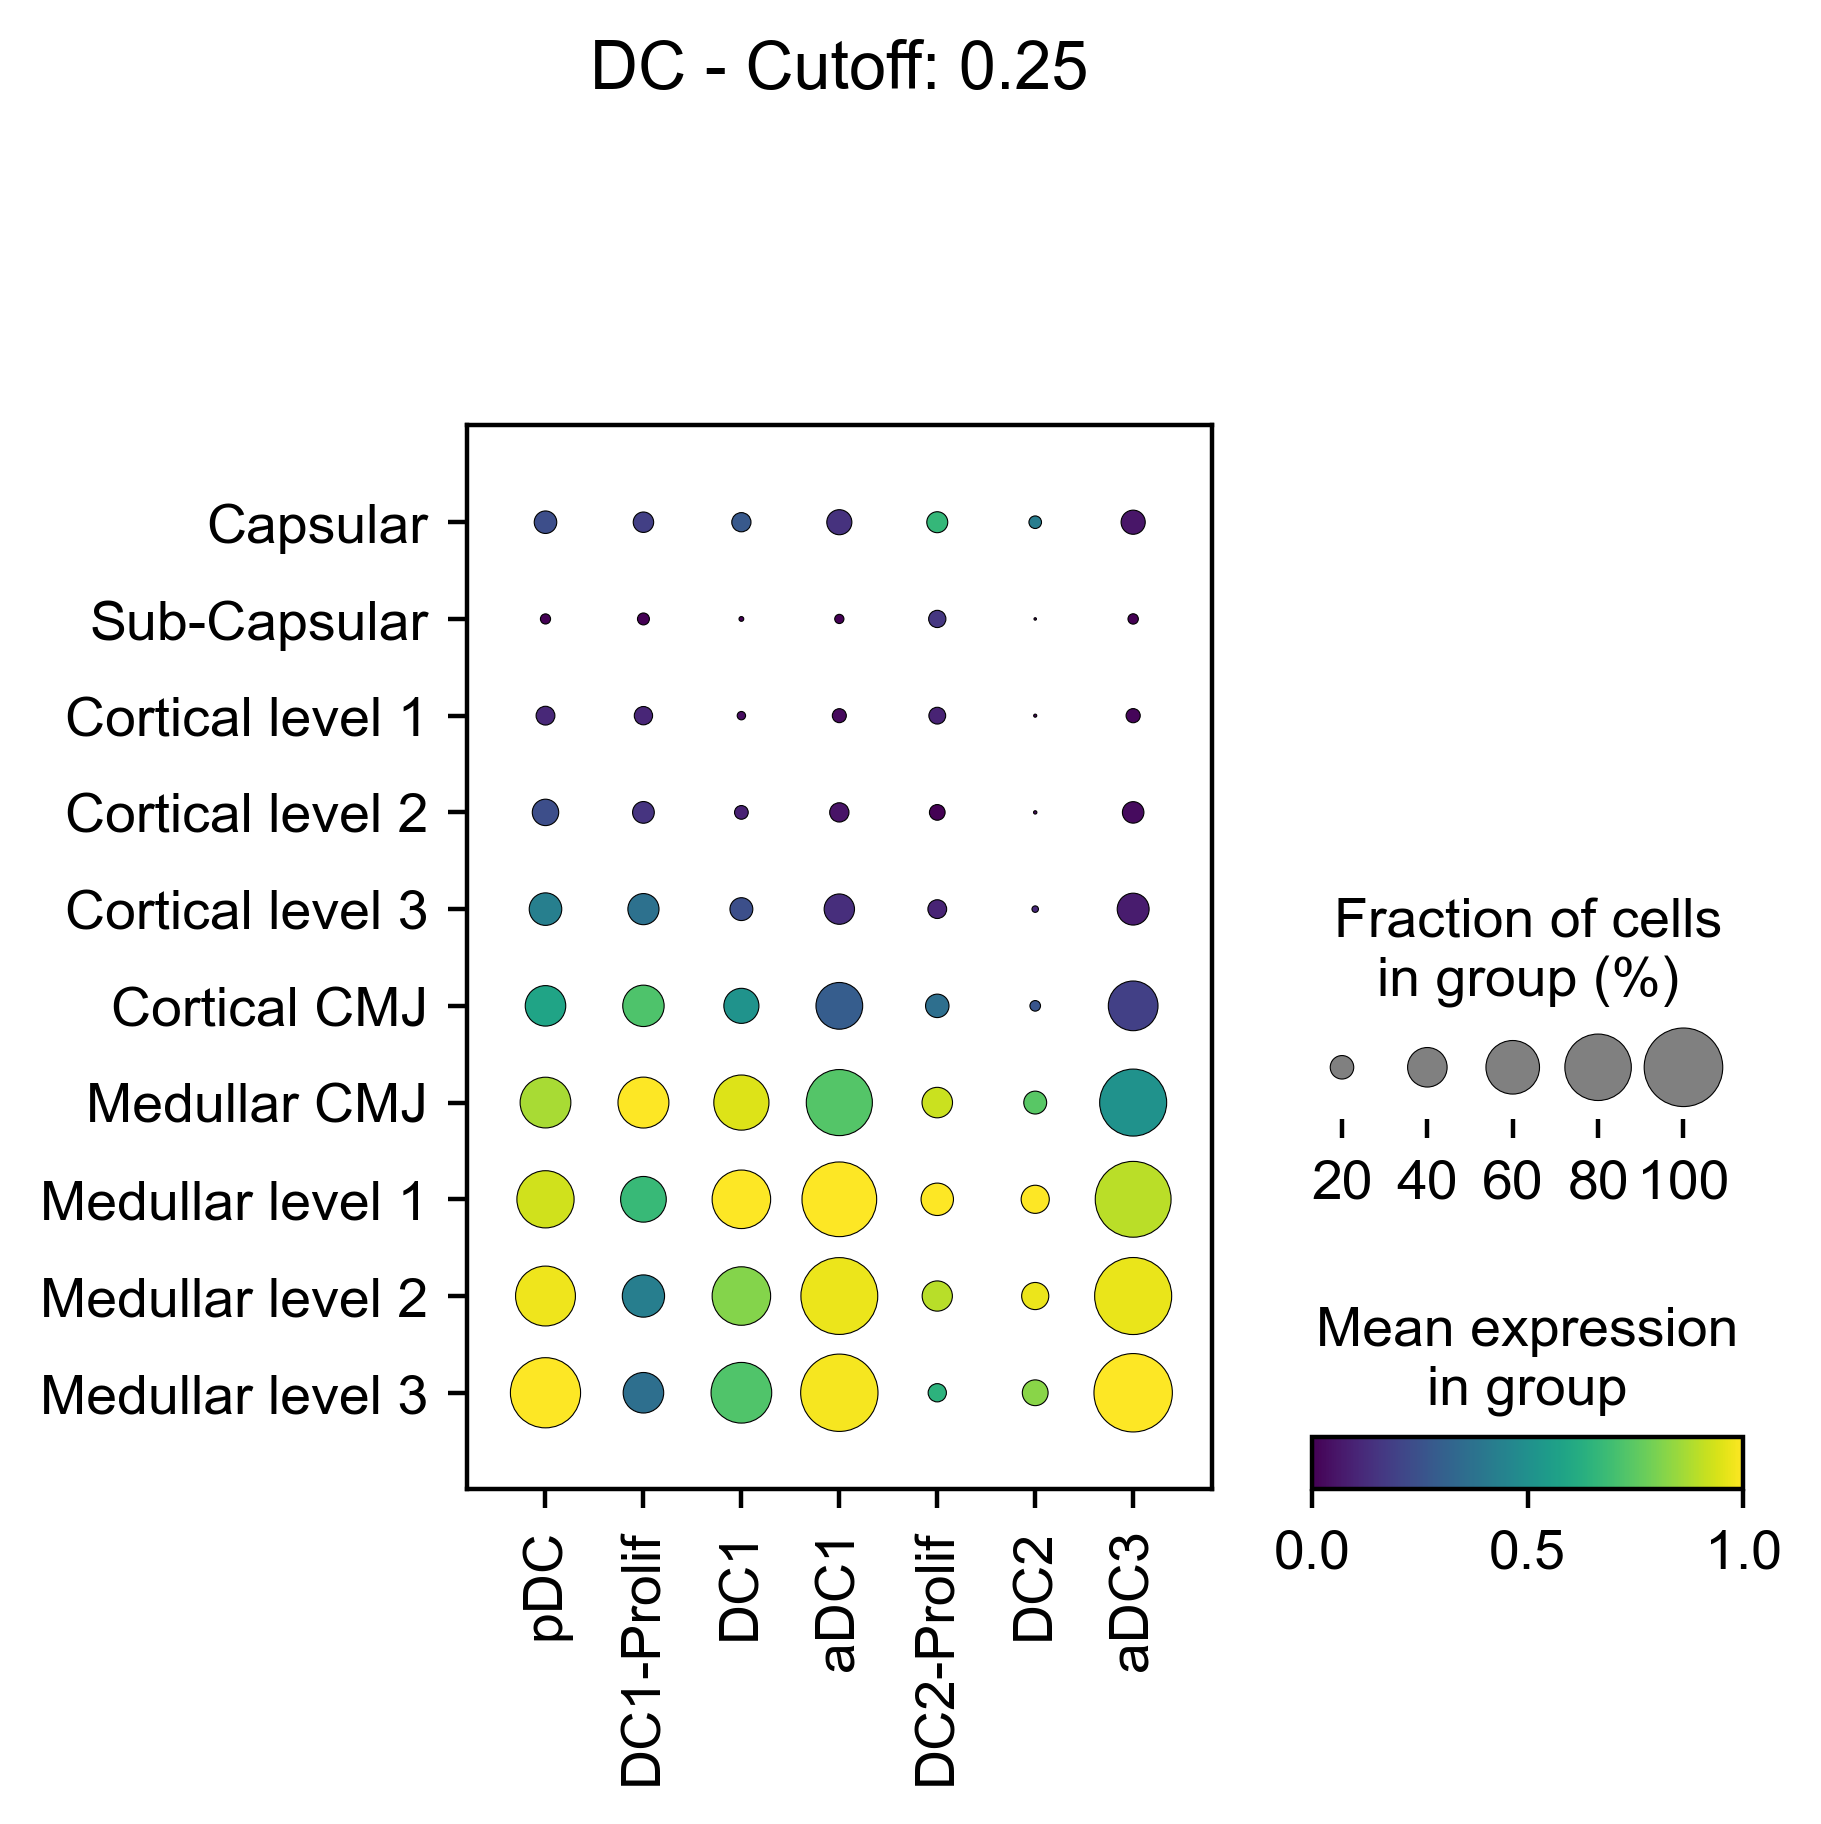

MAC
['Macrophage-APOC2', 'Macrophage-LYVE1', 'Macrophage-SPIC1']


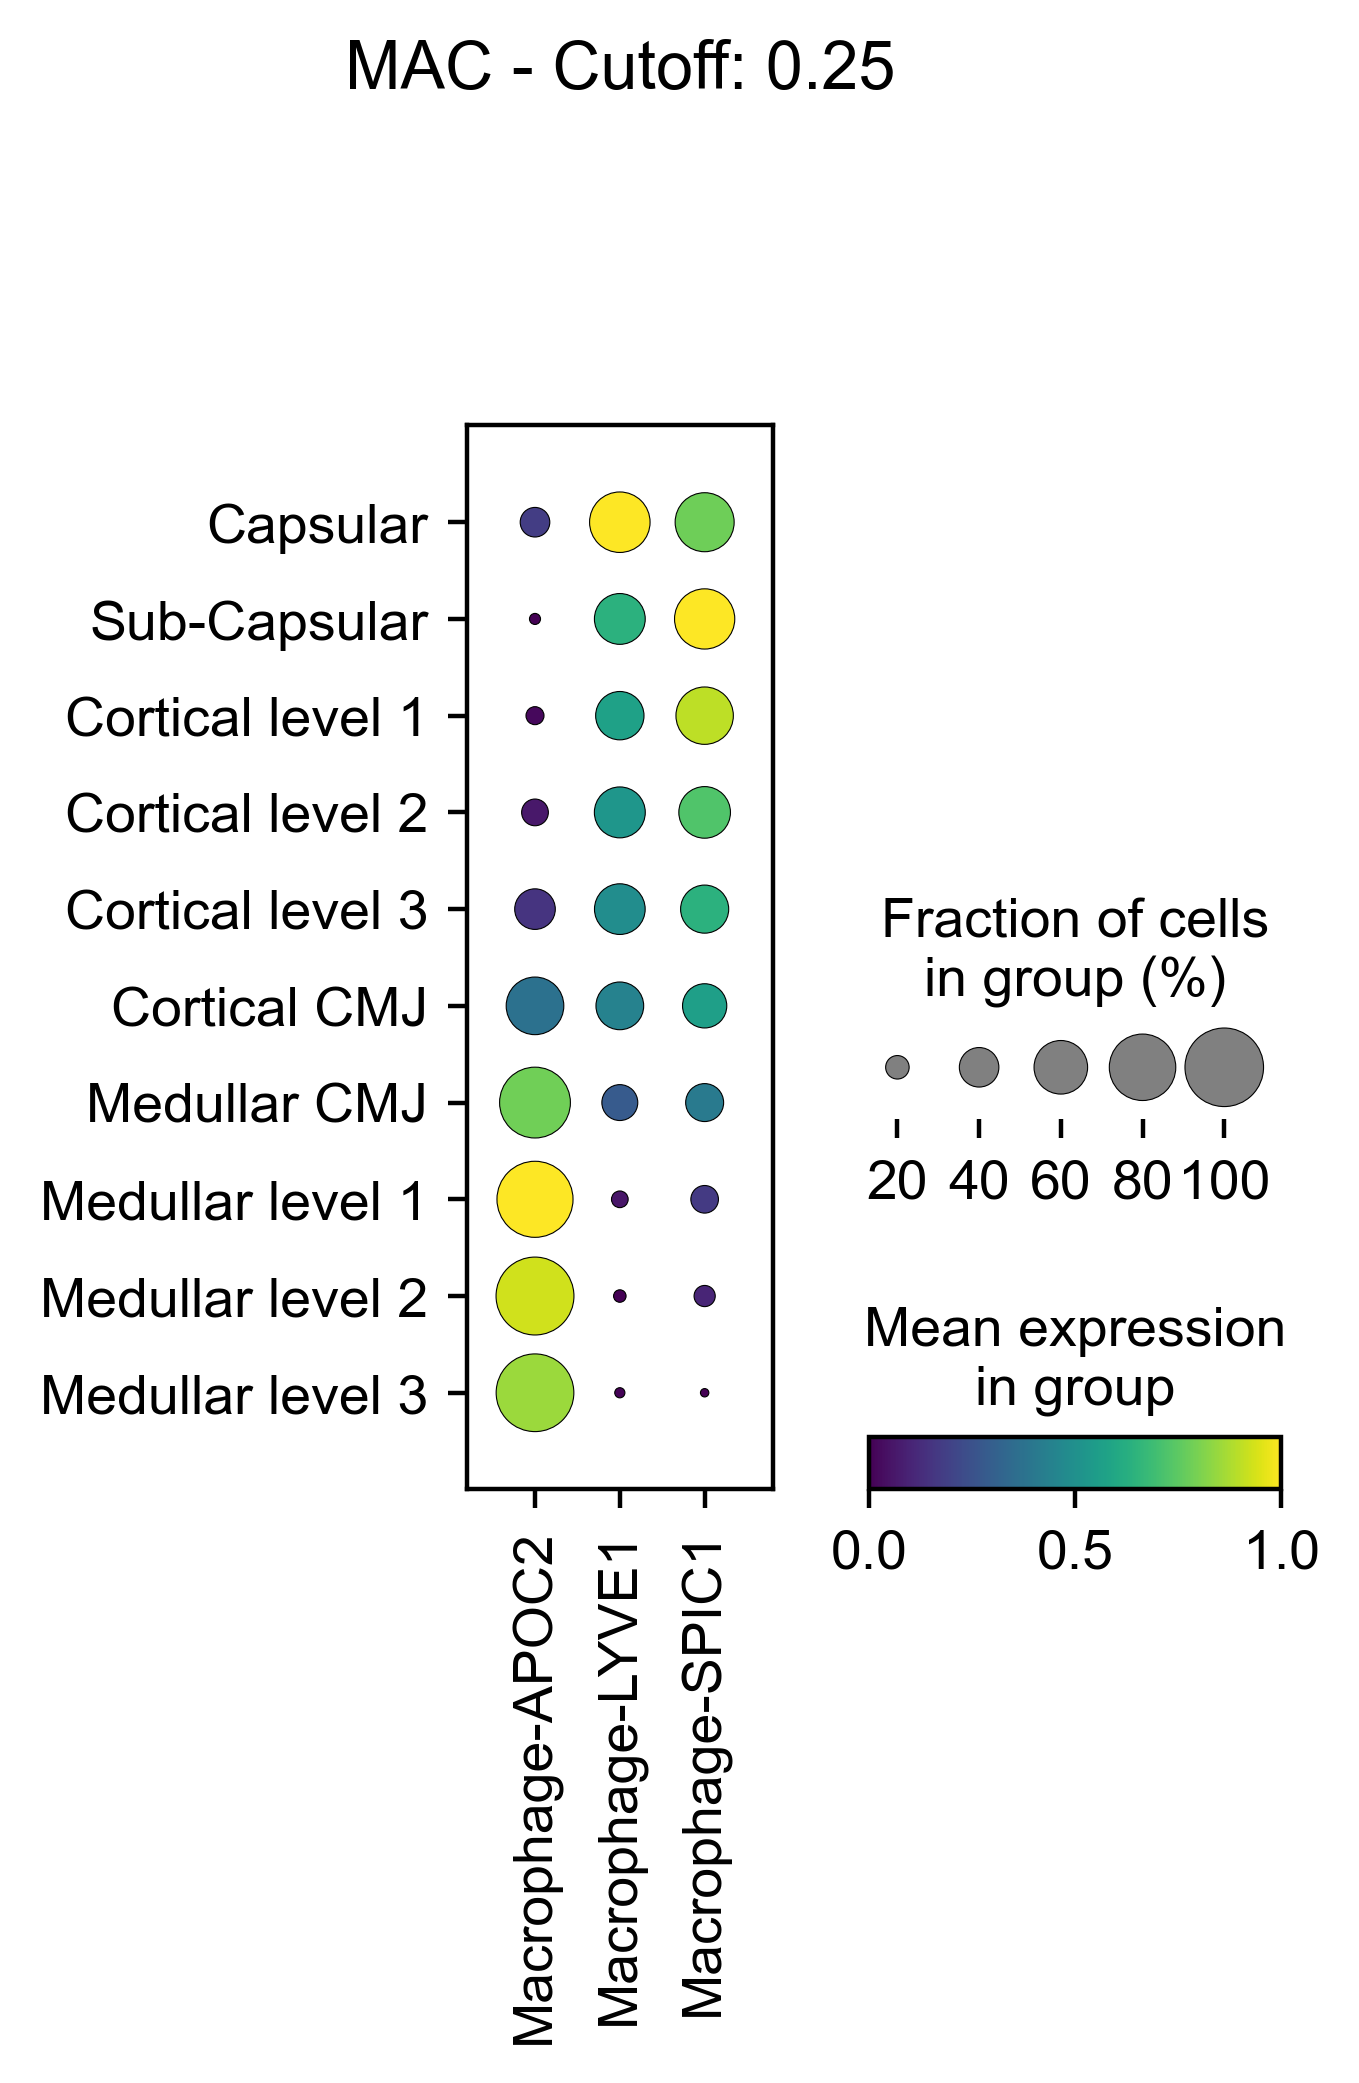

mono
['Monocyte_IL1B', 'Promonocyte', 'Mast', 'RBC']


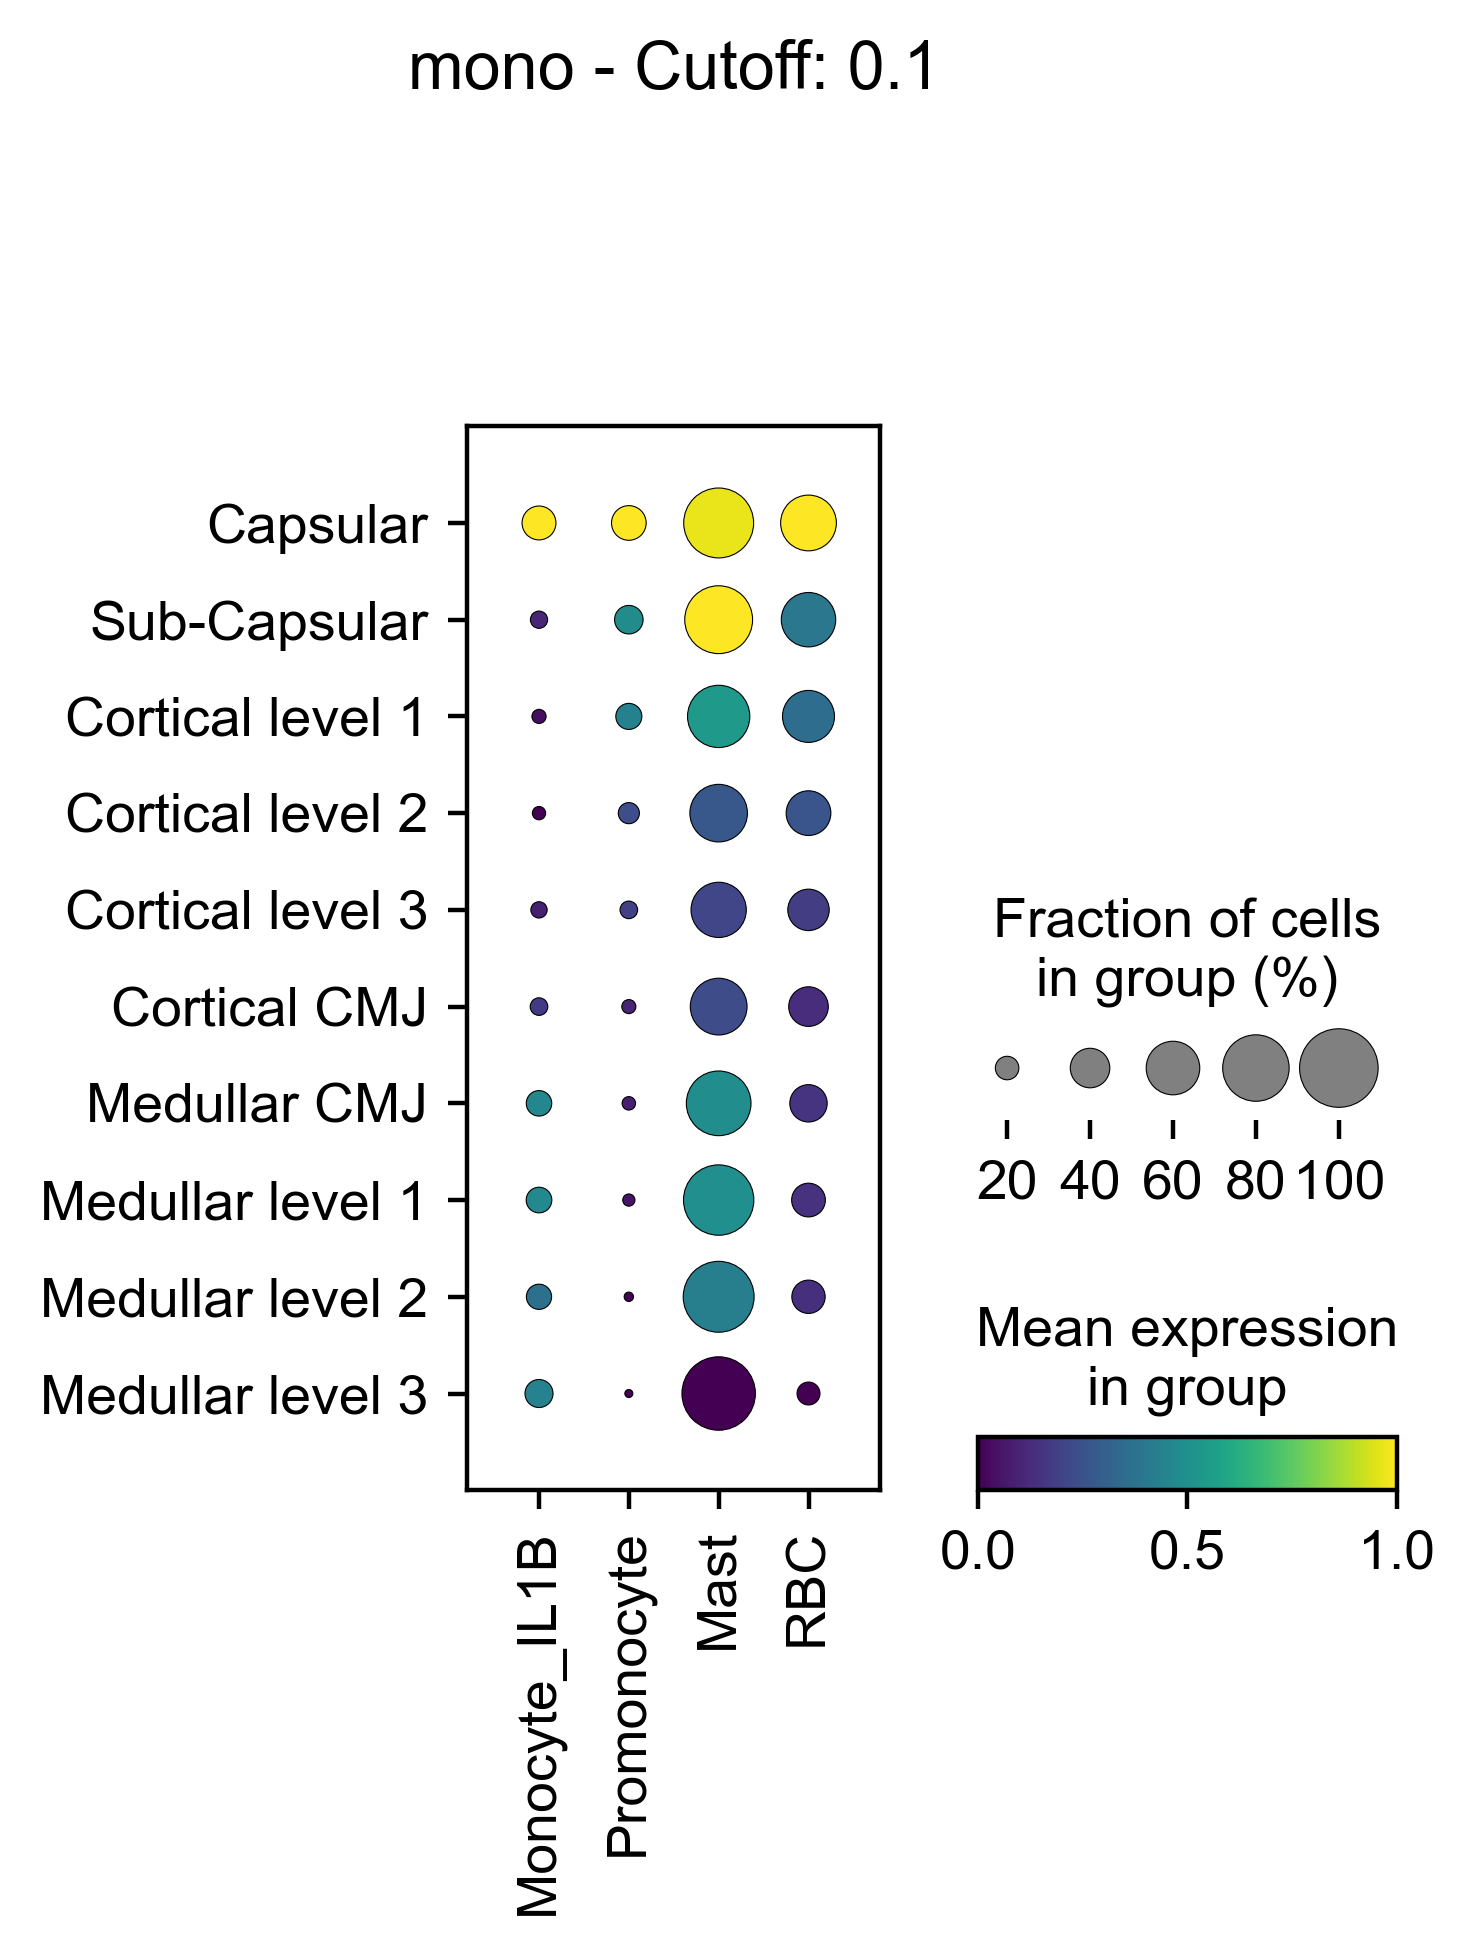

In [20]:
# subset cells supplemnetary myloid figure 
os.chdir('')

subset_keys = ['B','DC','MAC','mono']
cutoff = {'B':0.5,'DC':0.25,'MAC':0.25,'mono':0.1,}
cells_subset = {k: cells[k] for k in subset_keys}
 
sc.set_figure_params(figsize=[7, 7], fontsize=12, dpi=200)

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = None

#     save_path = f'fet_{cell}_cutoff_{cutoff[cell]}_.pdf'  # Construct the file name
#     dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
#               groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
#                       expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True, save=save_path)
#     export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff[cell]}_fetal_Visdotplot_source_data_")
#     dp.show()
#     dp.savefig(f'figures/{save_path}')
    sc.pl.dotplot(cellab_fet, var_names=cell_types,
                      groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                      expression_cutoff=cutoff[cell], standard_scale='var', save=save_path)

FB
['PeriloFb', 'PeriloFb-Prolif', 'InterloFb', 'InterloFb-COL9A3', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh']


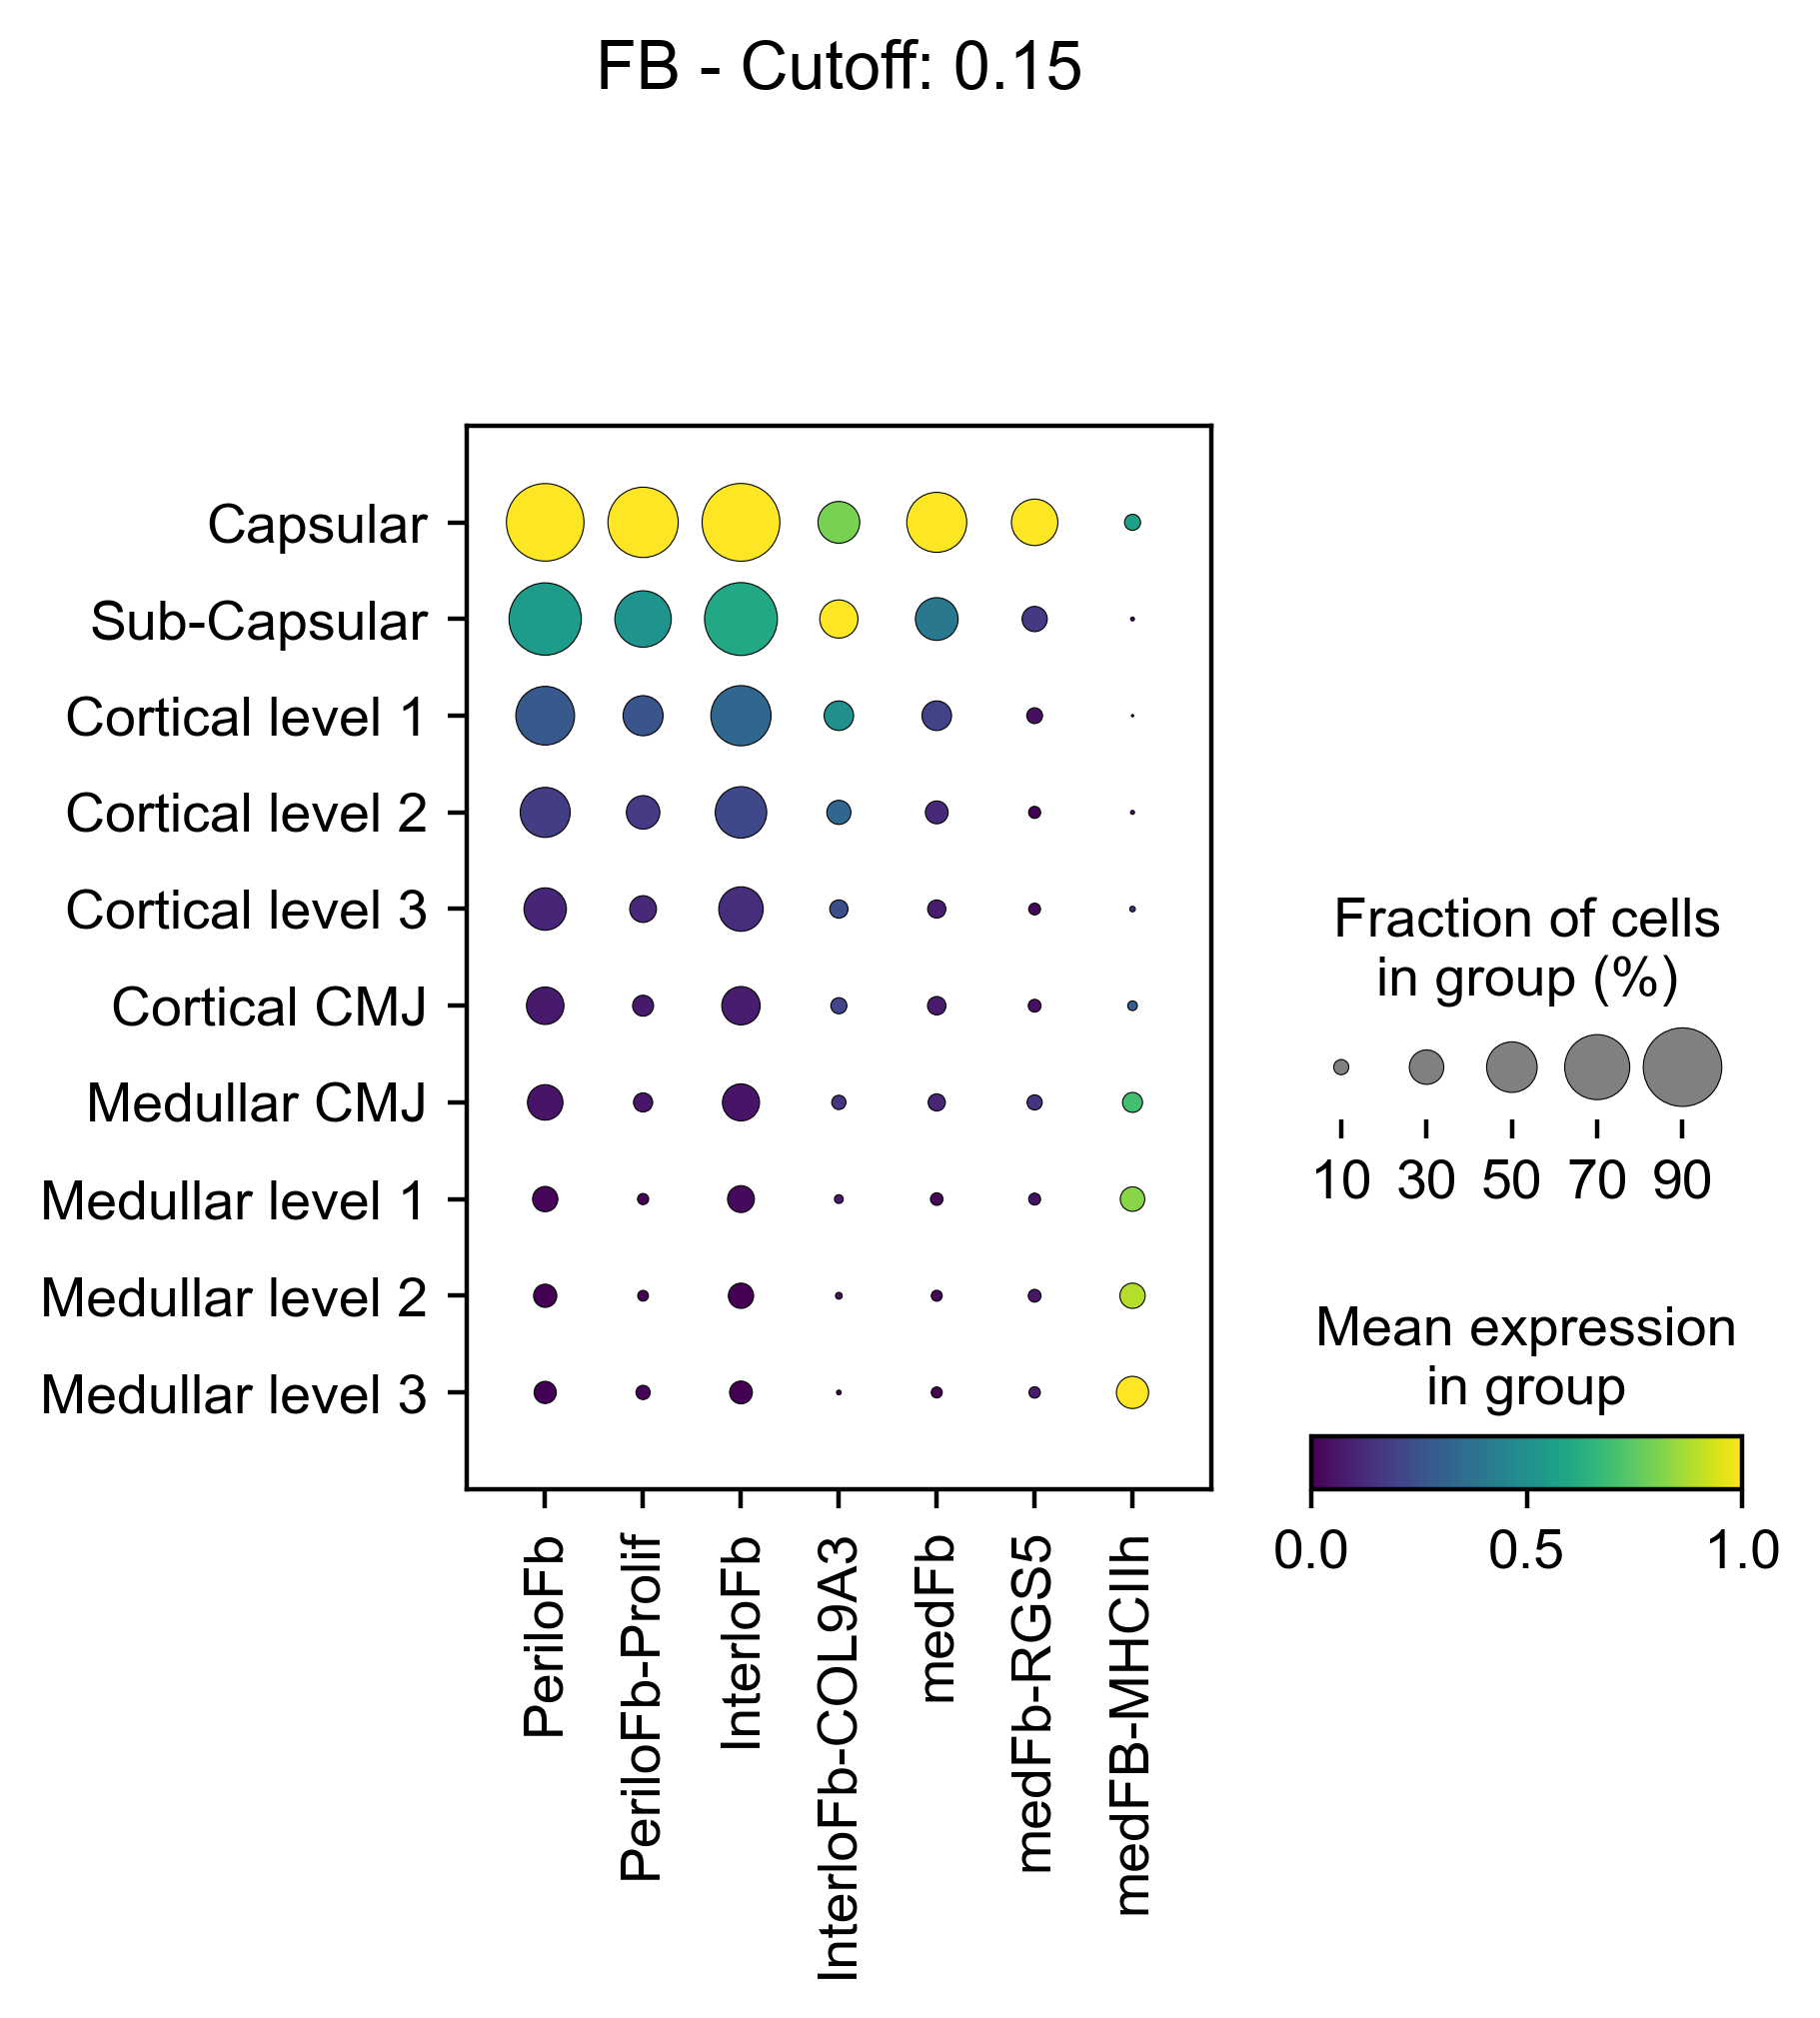

EC
['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif', 'EC-Ven', 'EC-Ven-ELN', 'EC-Lymphatic']


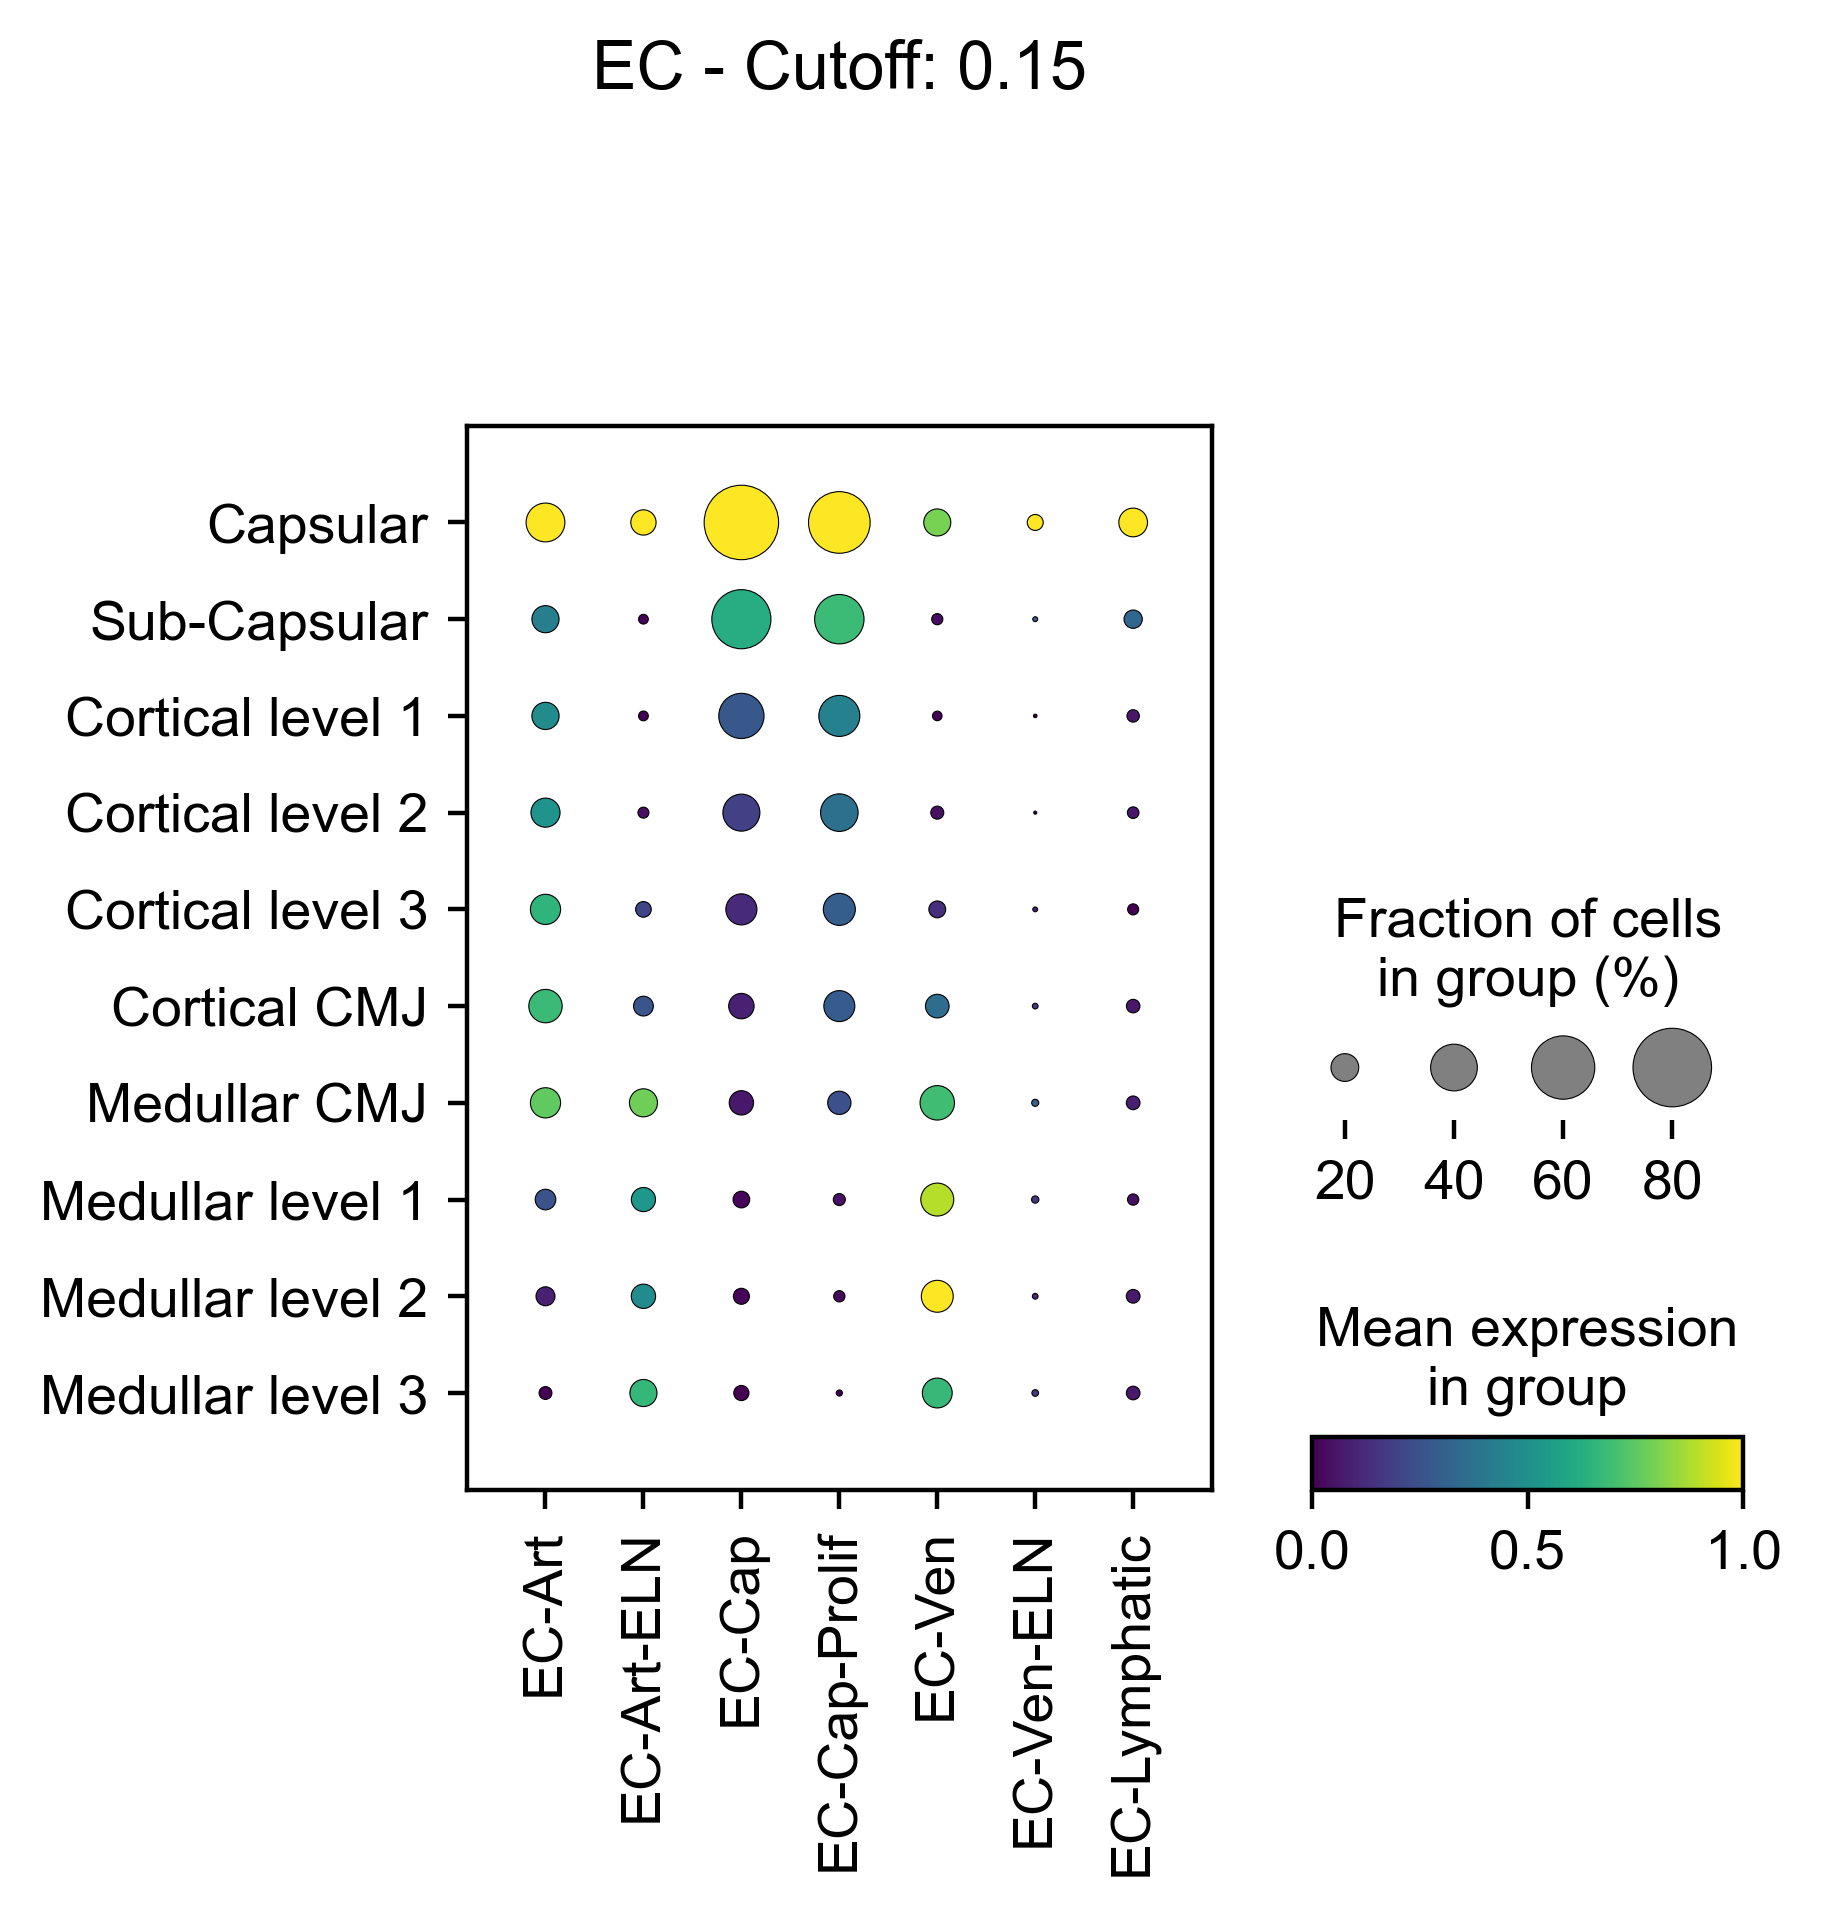

pericyte
['Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte', 'SMC']


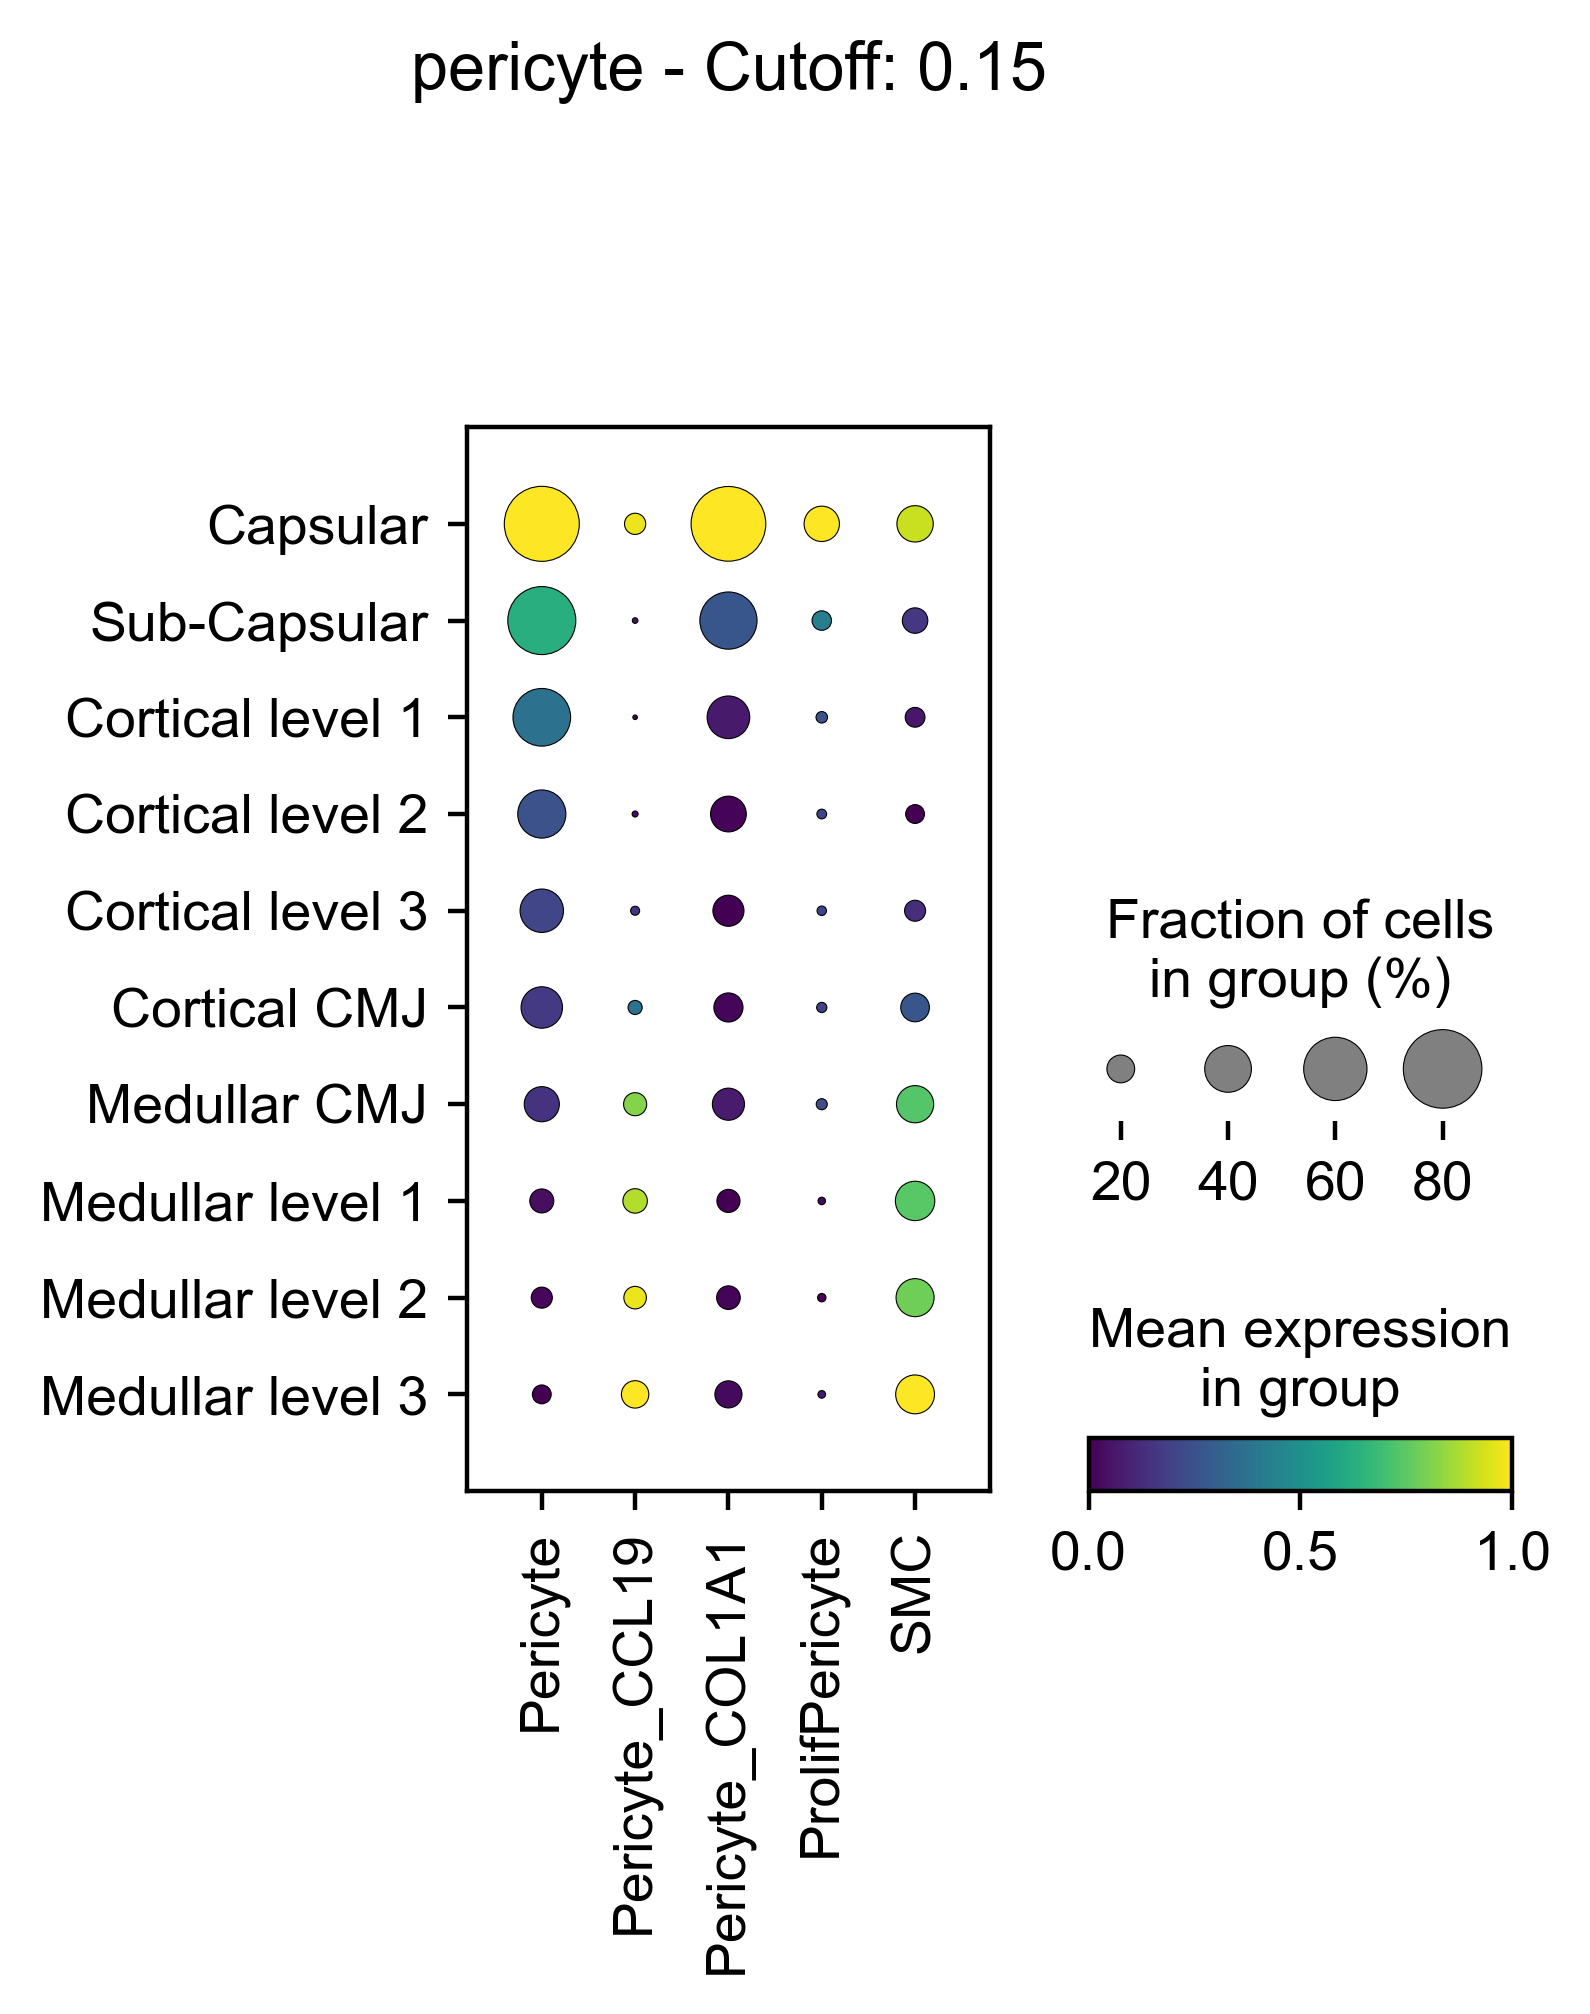

In [21]:
# subset cells supplemnetary FB figure 
os.chdir('')

subset_keys = ['FB','EC','pericyte']
cutoff = {'FB':0.15,'EC':0.15,'pericyte':0.15}
cells_subset = {k: cells[k] for k in subset_keys}
 
sc.set_figure_params(figsize=[7, 7], fontsize=12, dpi=200)

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = None

#     save_path = f'fet_{cell}_cutoff_{cutoff[cell]}_.pdf'  # Construct the file name
#     dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
#               groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
#                       expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True, save=save_path)
#     export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff[cell]}_fetal_Visdotplot_source_data_")
#     dp.show()
#     dp.savefig(f'figures/{save_path}')
    sc.pl.dotplot(cellab_fet, var_names=cell_types,
                      groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                      expression_cutoff=cutoff[cell], standard_scale='var', save=save_path)

TEC_special
['mTECI-trans', 'TEC-myo', 'TEC-neuro', 'TEC-cilliated']


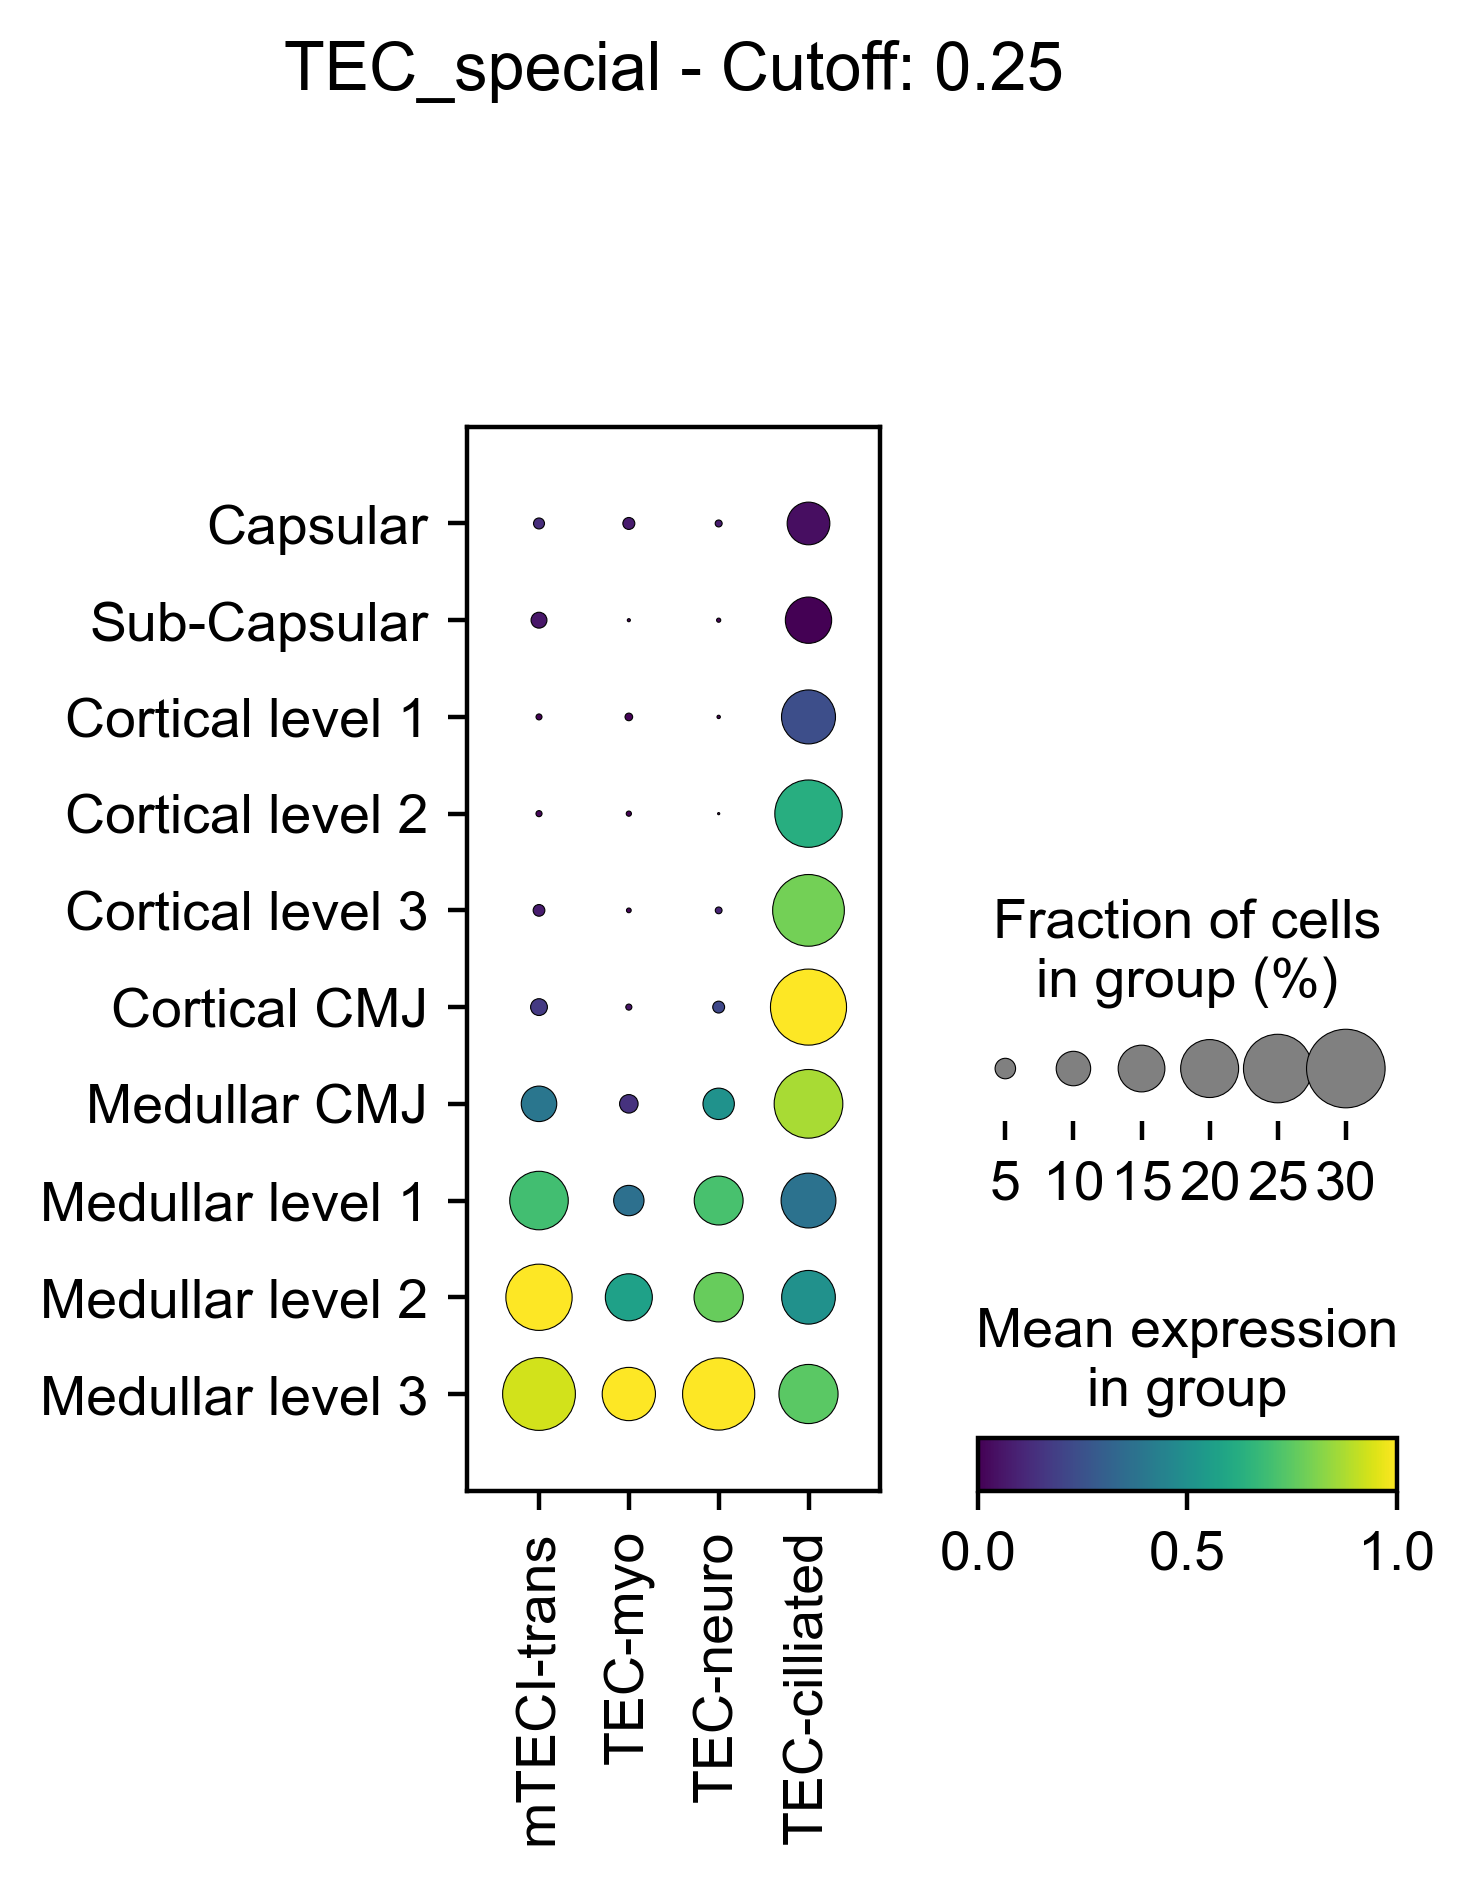

In [22]:
# subset cells extended TEC figure 
os.chdir('')

subset_keys = ['TEC_special']
cutoff = {'TEC_special':0.25}
cells_subset = {k: cells[k] for k in subset_keys}
for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = None

#     save_path = f'fet_{cell}_cutoff_{cutoff[cell]}_.pdf'  # Construct the file name
#     dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
#               groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
#                       expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True, save=save_path)
#         export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff[cell]}_fetal_Visdotplot_source_data_")
#         dp.show()
    sc.pl.dotplot(cellab_fet, var_names=cell_types,
                              groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                              expression_cutoff=cutoff[cell], standard_scale='var', save=save_path)

# plot TECs figure 4 

TEC_fig4
['cTECII', 'cTECI', 'mcTEC-Prolif', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII']


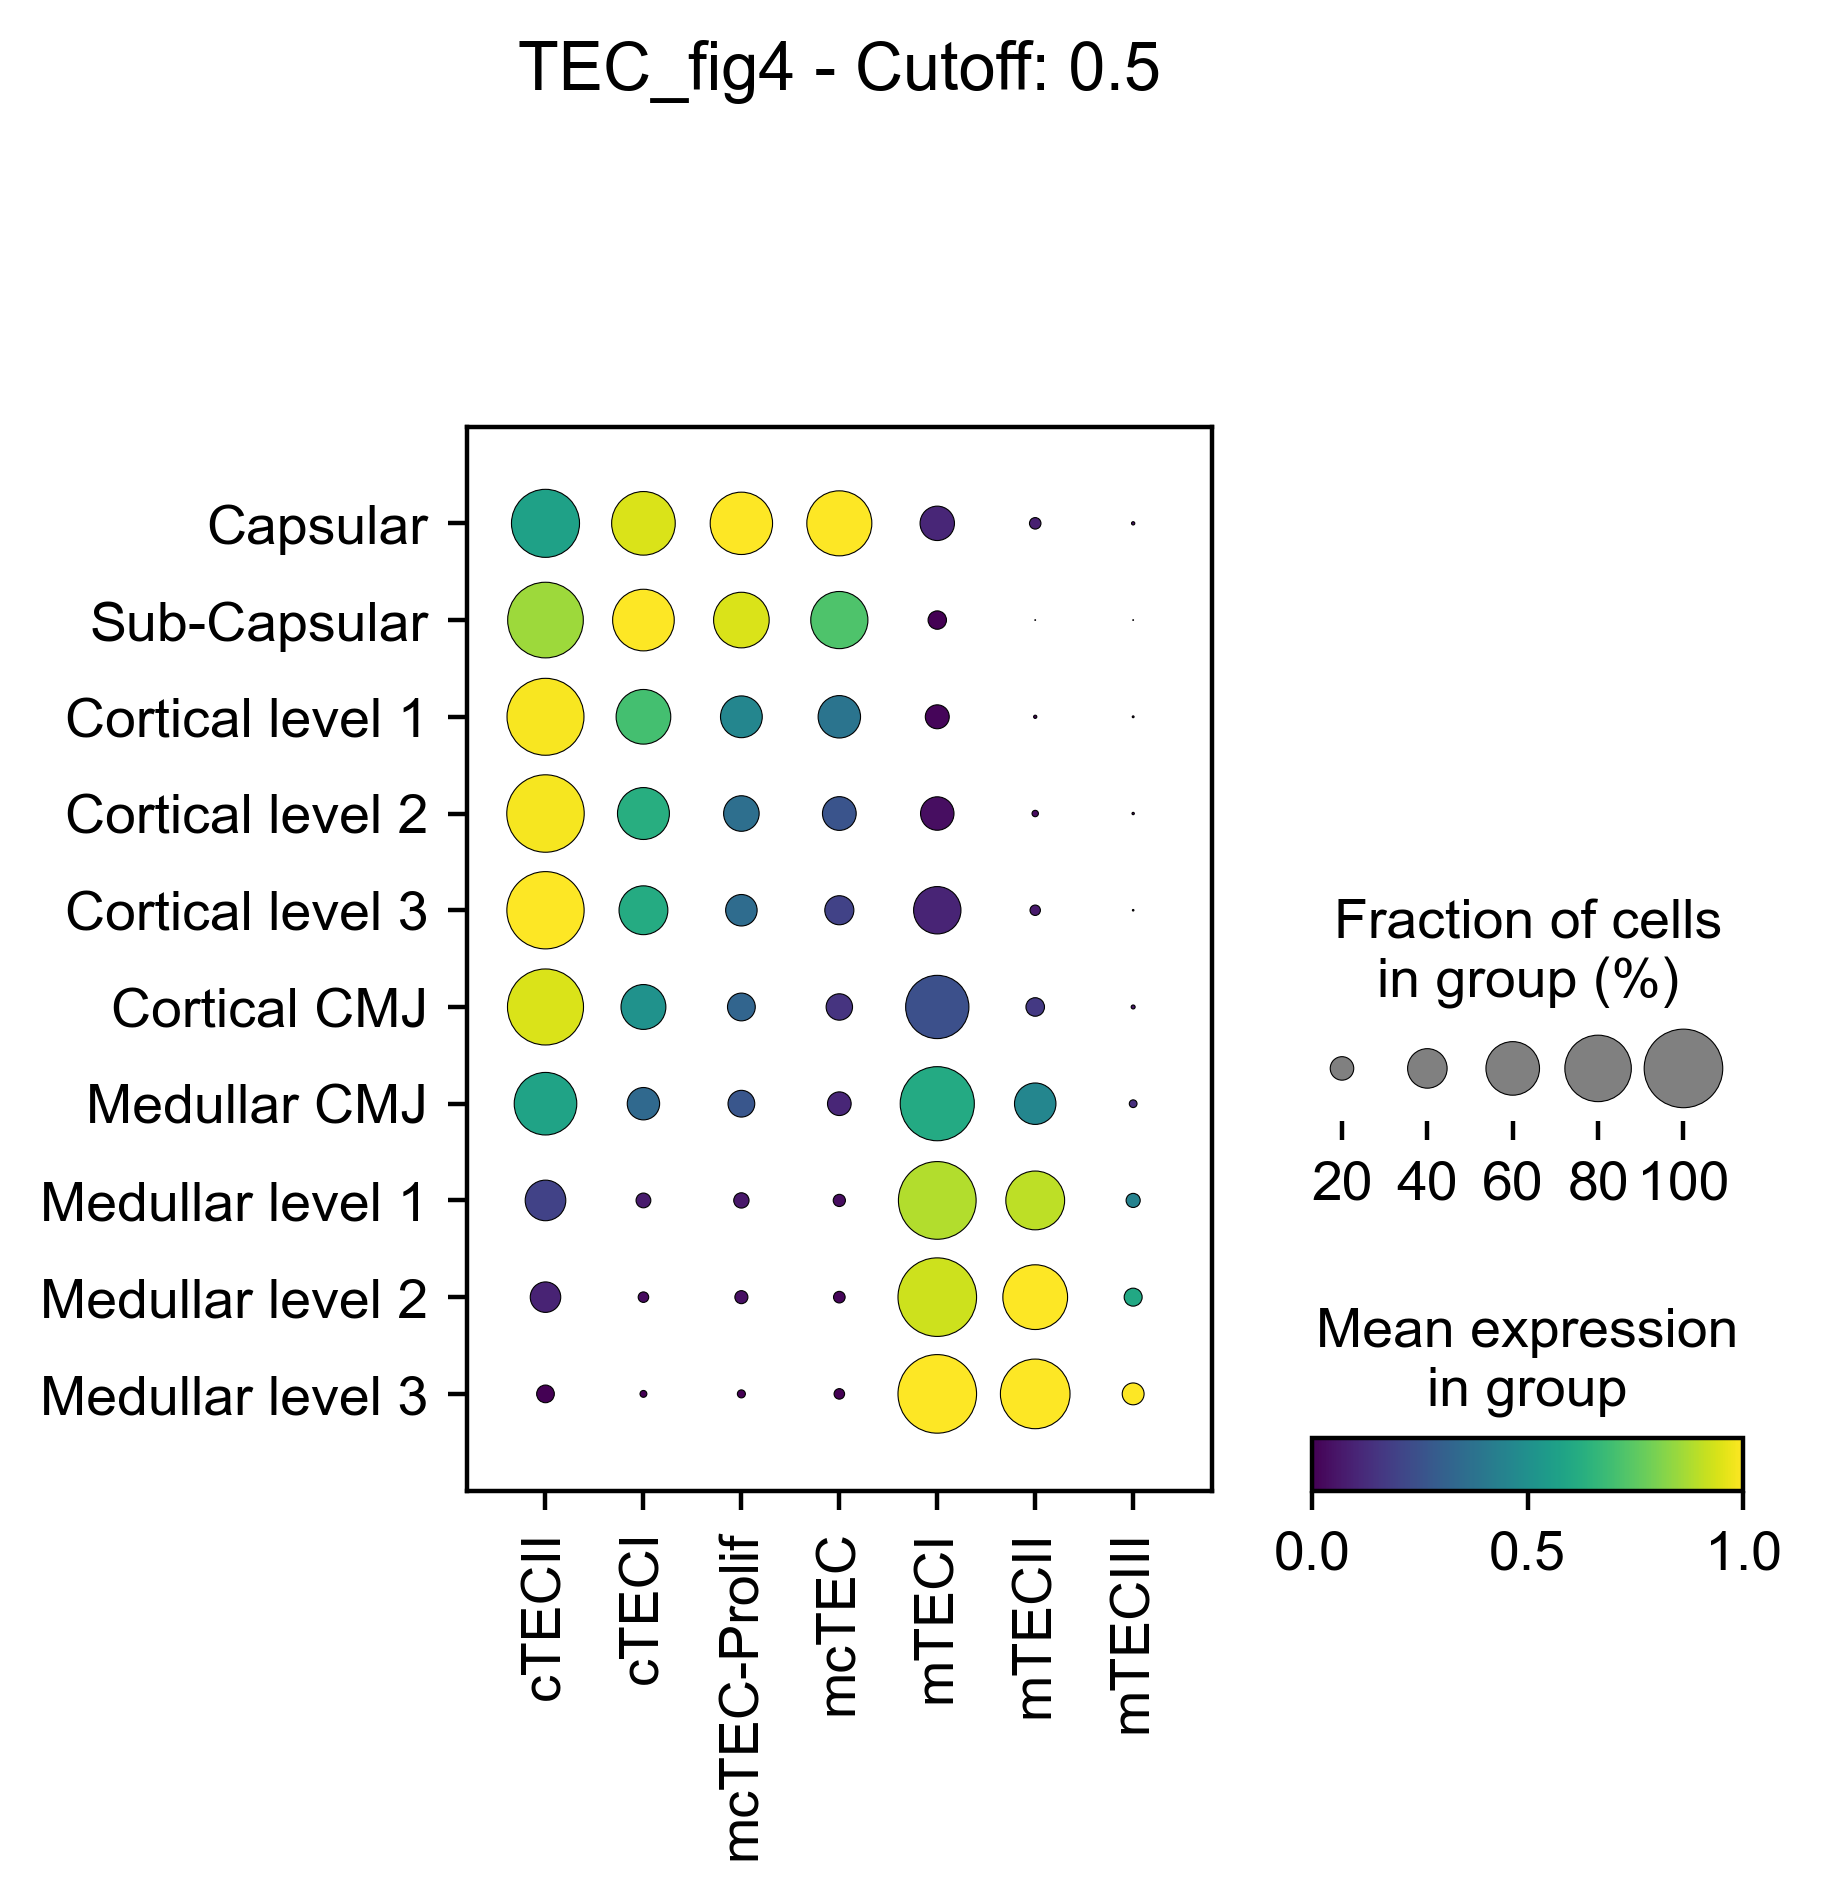

In [23]:
# subset cells
os.chdir('')

subset_keys = ['TEC_fig4']
cells_subset = {k: cells[k] for k in subset_keys}
cutoff = {'TEC_fig4':0.5}

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = None

#     save_path = f'fetal_{cell}_cutoff_{cutoff[cell]}_.pdf'  # Construct the file name
#     dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
#                           groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
#                           expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True, save=save_path)
#     export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff}_fetal_Visdotplot_source_data_")
#           dp.show()
#           dp.savefig(f'figures/{save_path}')
    sc.pl.dotplot(cellab_fet, var_names=cell_types,
                              groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                              expression_cutoff=cutoff[cell], standard_scale='var', save=save_path)

 # Extended figure TEC 

TEC_fig4
['cTECII', 'cTECI', 'mcTEC-Prolif', 'mcTEC', 'mTECI', 'mTECII', 'mTECIII']


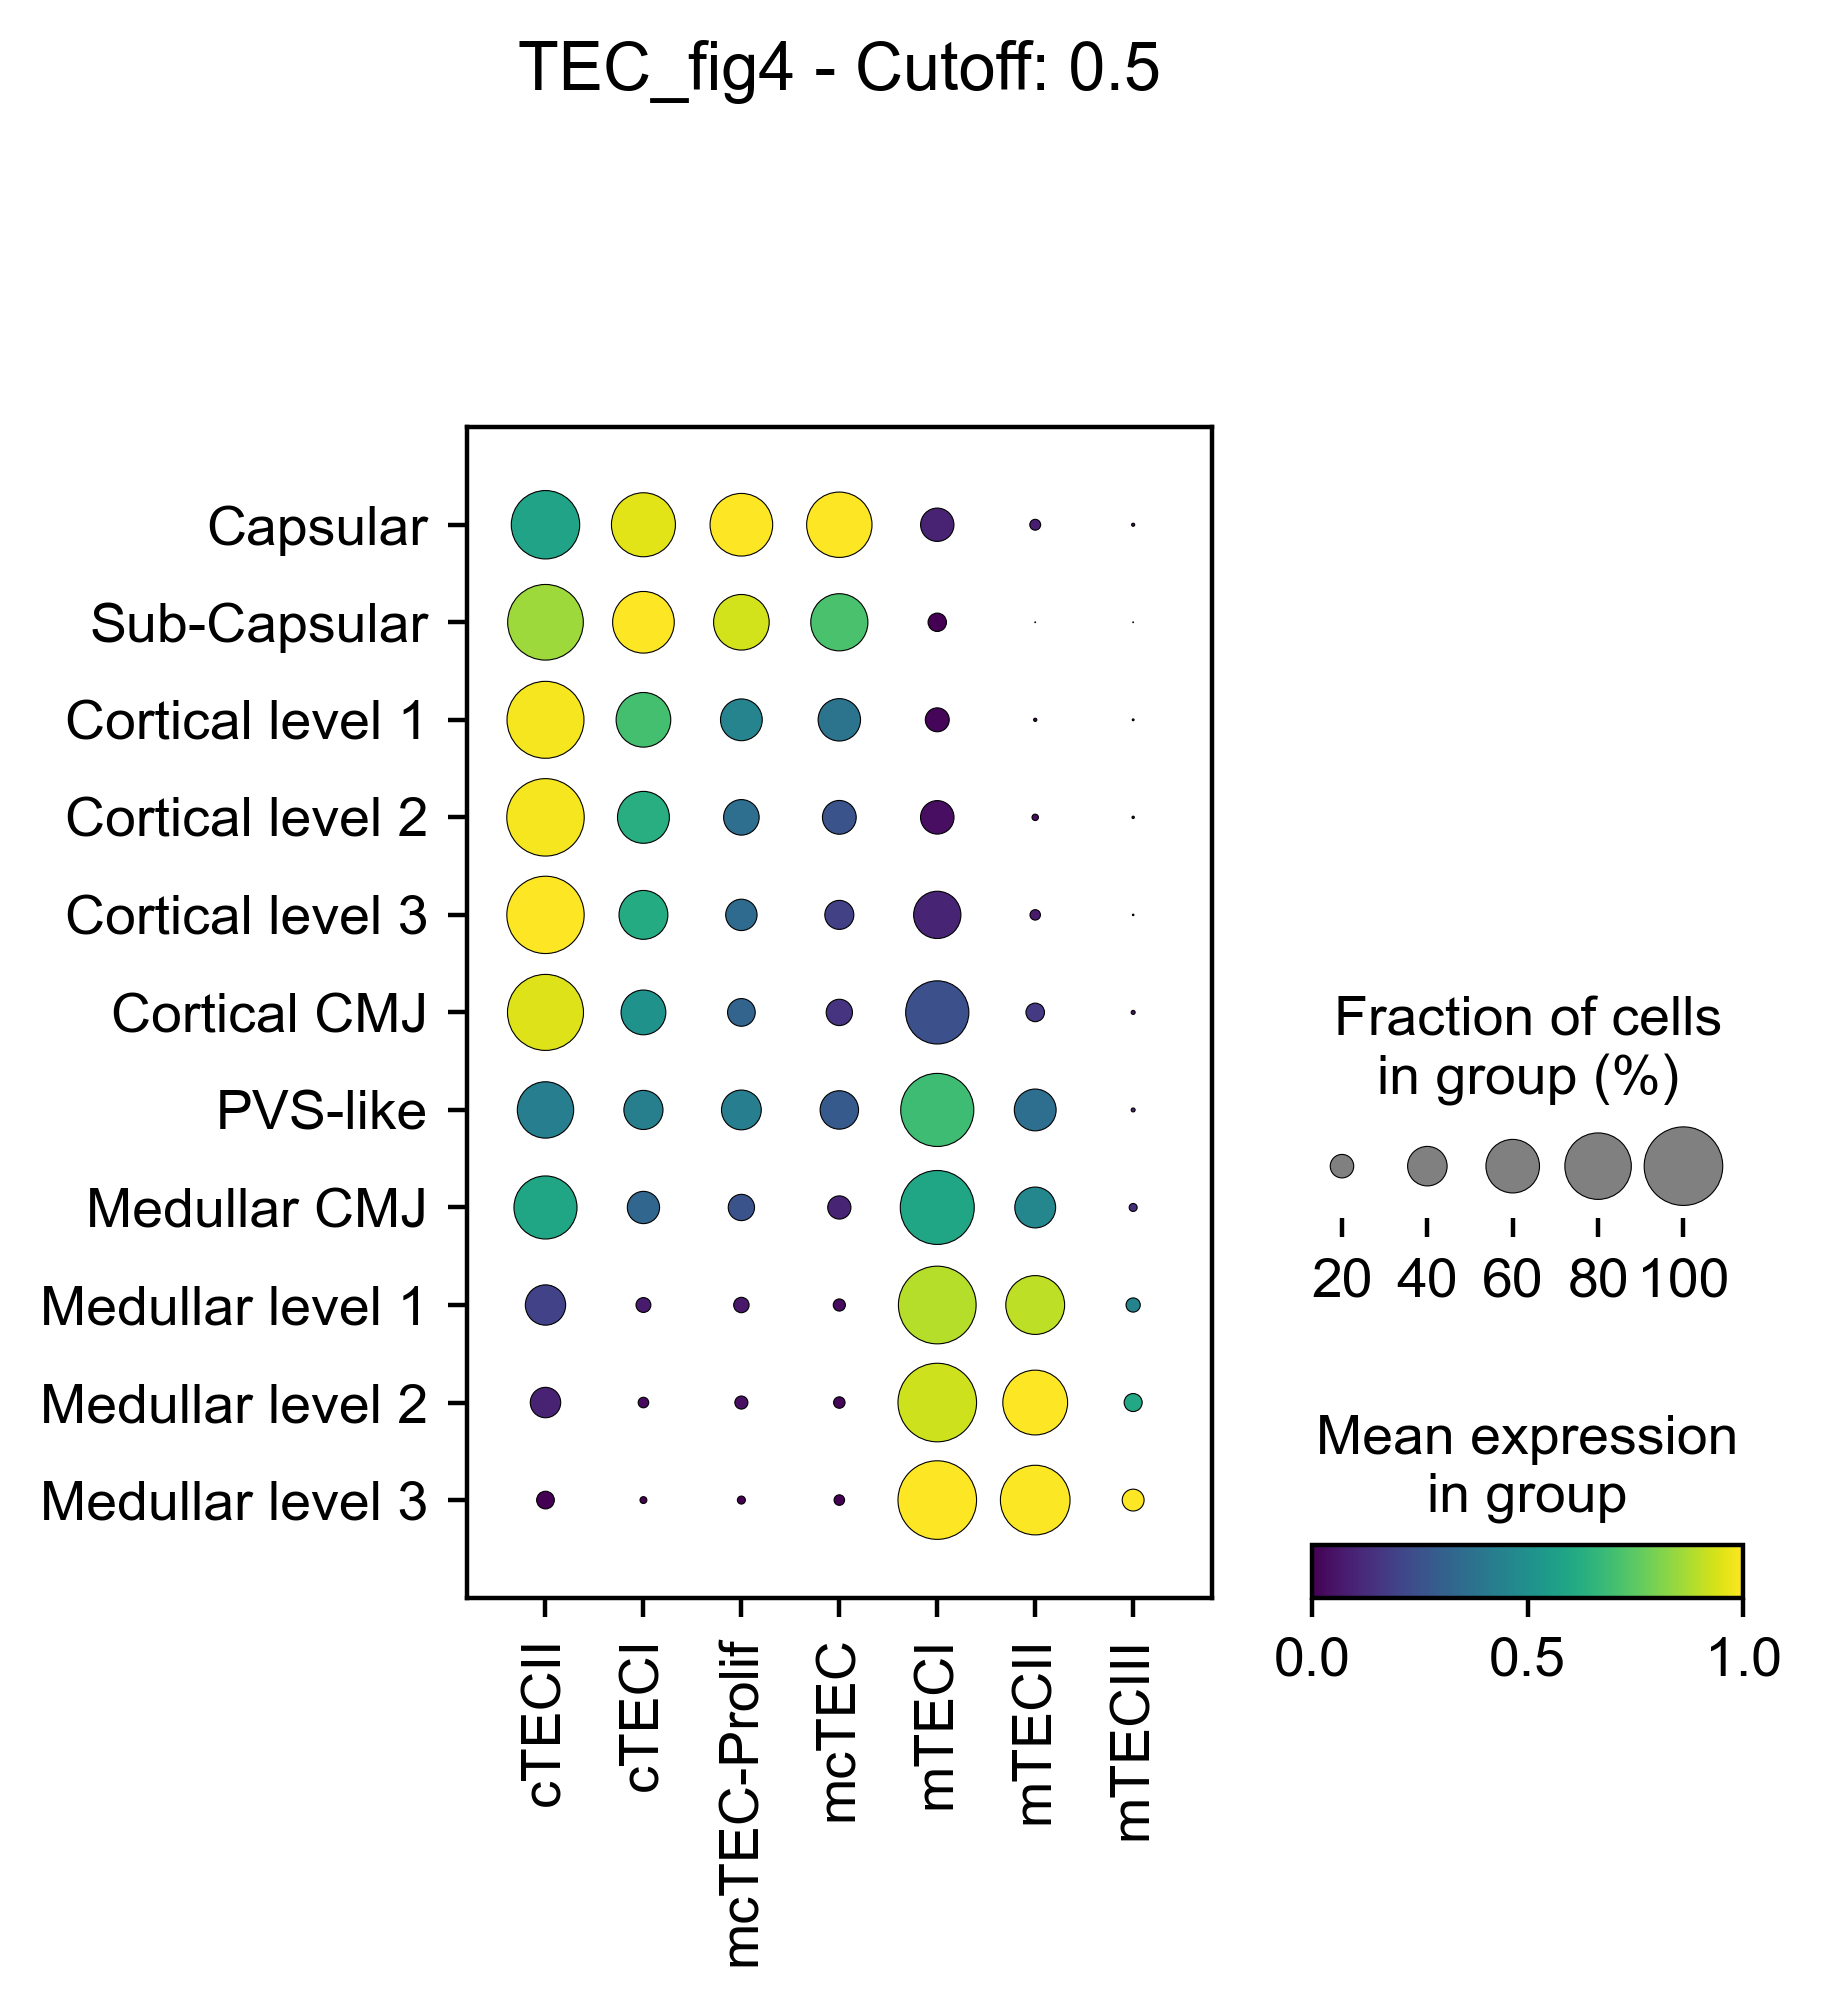

In [53]:
os.chdir('')
cellab_fet.obs['manual_bin_cma_v2'] = cellab_fet.obs['manual_bin_cma_v2'].astype('string')
cellab_fet.obs.loc[cellab_fet.obs['annotations_level_1']=='PVS','manual_bin_cma_v2'] = 'PVS-like'
cellab_fet.obs['manual_bin_cma_v2'] = cellab_fet.obs['manual_bin_cma_v2'].astype('category')

ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','PVS-like','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
cellab_fet.obs['manual_bin_cma_v2'] = cellab_fet.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
subset_keys = ['TEC_fig4']
cells_subset = {k: cells[k] for k in subset_keys}
 
sc.set_figure_params(figsize=[7, 7], fontsize=12, dpi=200)

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    for cutoff in [0.5]:
        save_path = f'fet_PVS_{cell}_cutoff_{cutoff}.pdf'  # Construct the file name
        dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
                      groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff}',
                      expression_cutoff=cutoff, standard_scale='var', return_fig = True) #save=save_path)
#         export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}extended_{cutoff}_fetal_Visdotplot_source_data")
        dp.show()


In [13]:

adata_fet_cma.obs[['DonorID','Age(misc)']].value_counts()

DonorID  Age(misc)
F121     16pcw        2333
F133     17pcw        2160
F130     12pcw        1658
F136     18pcw        1357
F114     15pcw        1127
F135     16pcw         979
F113     12pcw         468
dtype: int64